# <div align="center"> COSC 2673/2793 | Machine Learning </div>

## <div align="center"> Assignment 2 - Joseph Packham (s3838978) and Kylie Nguyen (s3946026) </div>


# Introduction

This report will cover the process of producing a machine learning model that will predict energy usage...


In [353]:
# importing packages
# import seaborn package for plotting scatterplots
import seaborn as sns

import pandas as pd



import matplotlib.pyplot as plt


import numpy as np


from sklearn.model_selection import train_test_split


import tensorflow as tf


import pydot as pyd


from tensorflow.keras.metrics import MeanAbsoluteError


from sklearn.preprocessing import StandardScaler


from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras import regularizers


from tensorflow.keras.layers import Dropout, BatchNormalization


from sklearn.preprocessing import PowerTransformer


from tensorflow.keras.optimizers import Adam


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.utils import compute_sample_weight
from tensorflow.keras.losses import Huber

In [354]:
# read in CSV file and display first 5 rows
energyUse_df = pd.read_csv("./dataset/UCI-electricity/UCI_data.csv", delimiter=",")
energyUse_df.head()

date         T1       RH_1         T2       RH_2         T3  \
0  2016-04-19 20:30:00  22.200000  39.500000  20.566667  37.656667  22.230000   
1  2016-03-05 04:40:00  20.356667  37.126667  17.566667  40.230000  20.890000   
2  2016-03-14 12:40:00  20.926667  38.790000  21.100000  35.526667  21.600000   
3  2016-01-22 15:30:00  18.290000  38.900000  17.290000  39.260000  18.390000   
4  2016-02-10 00:40:00  22.290000  42.333333  21.600000  40.433333  22.666667   

        RH_3         T4       RH_4         T5  ...   RH_9  T_out  Press_mm_hg  \
0  37.030000  22.318571  36.610000  20.633333  ...  33.90   9.70   766.100000   
1  37.663333  18.700000  36.260000  18.463333  ...  41.09   0.30   740.333333   
2  36.290000  21.000000  34.826667  18.100000  ...  38.76   4.40   768.466667   
3  39.326667  16.100000  38.790000  16.100000  ...  39.20   3.35   760.600000   
4  43.363333  19.100000  40.900000  19.290000  ...  43.73   3.20   738.900000   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  \
0    65.5   3.500000   40.000000   3.350000  24.061869  24.061869   
1    99.0   1.000000   41.333333   0.100000   4.622052   4.622052   
2    72.0   6.000000   22.666667  -0.266667   5.635898   5.635898   
3    82.0   5.500000   41.000000   0.500000  49.216445  49.216445   
4    88.0   7.333333   56.000000   1.400000  47.617579  47.617579   

   TARGET_energy  
0             60  
1             50  
2             80  
3             40  
4             60  

[5 rows x 28 columns]

# Exploratory Data Analysis

First, the data is investigated through EDA. It is observed that the shape of the dataframe is 19735 rows of data with 28 columns, where 1 column is the target variable (energy usage in Wh), and the remaining columns are the attributes. According to the description of the data, these attributes cover the temperature and humidity of different rooms in the house, as well as outside, along with a few other weather related variables such as pressure and windspeed. It is noted that there are two variables listed as "Random Variable". Using the .info() function, it is confirmed that there are no null values within the dataset.


In [355]:
# check for any null values, using shape to compare
print("Shape of Energy Use dataframe: ", energyUse_df.shape, "\n")

energyUse_df.info()

Shape of Energy Use dataframe:  (19735, 28) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19735 non-null  object 
 1   T1             19735 non-null  float64
 2   RH_1           19735 non-null  float64
 3   T2             19735 non-null  float64
 4   RH_2           19735 non-null  float64
 5   T3             19735 non-null  float64
 6   RH_3           19735 non-null  float64
 7   T4             19735 non-null  float64
 8   RH_4           19735 non-null  float64
 9   T5             19735 non-null  float64
 10  RH_5           19735 non-null  float64
 11  T6             19735 non-null  float64
 12  RH_6           19735 non-null  float64
 13  T7             19735 non-null  float64
 14  RH_7           19735 non-null  float64
 15  T8             19735 non-null  float64
 16  RH_8           19735 non-null  float64
 17  T9  

Using the describe function, the count, mean, standard deviation, quantiles and the minimum and maximum values of the data are returned. With these values it is seen that, although the range of the values among the variables regarding humidity and temperature are relatively similar, there are cases where the range differs greatly. For example, the range of Windspeed is between 0-14, whereas the range of target energy is between 10-1110. This suggests that feature scaling should be done later in the process, as the differing ranges may cause problems or confuse the learning algorithms.


In [356]:
energyUse_df.describe()

T1          RH_1            T2          RH_2            T3  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      21.686571     40.259739     20.341219     40.420420     22.267611   
std        1.606066      3.979299      2.192974      4.069813      2.006111   
min       16.790000     27.023333     16.100000     20.463333     17.200000   
25%       20.760000     37.333333     18.790000     37.900000     20.790000   
50%       21.600000     39.656667     20.000000     40.500000     22.100000   
75%       22.600000     43.066667     21.500000     43.260000     23.290000   
max       26.260000     63.360000     29.856667     56.026667     29.236000   

               RH_3            T4          RH_4            T5          RH_5  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      39.242500     20.855335     39.026904     19.592106     50.949283   
std        3.254576      2.042884      4.341321      1.844623      9.022034   
min       28.766667     15.100000     27.660000     15.330000     29.815000   
25%       36.900000     19.530000     35.530000     18.277500     45.400000   
50%       38.530000     20.666667     38.400000     19.390000     49.090000   
75%       41.760000     22.100000     42.156667     20.619643     53.663333   
max       50.163333     26.200000     51.090000     25.795000     96.321667   

       ...          RH_9         T_out   Press_mm_hg        RH_out  \
count  ...  19735.000000  19735.000000  19735.000000  19735.000000   
mean   ...     41.552401      7.411665    755.522602     79.750418   
std    ...      4.151497      5.317409      7.399441     14.901088   
min    ...     29.166667     -5.000000    729.300000     24.000000   
25%    ...     38.500000      3.666667    750.933333     70.333333   
50%    ...     40.900000      6.916667    756.100000     83.666667   
75%    ...     44.338095     10.408333    760.933333     91.666667   
max    ...     53.326667     26.100000    772.300000    100.000000   

          Windspeed    Visibility     Tdewpoint           rv1           rv2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean       4.039752     38.330834      3.760707     24.988033     24.988033   
std        2.451221     11.794719      4.194648     14.496634     14.496634   
min        0.000000      1.000000     -6.600000      0.005322      0.005322   
25%        2.000000     29.000000      0.900000     12.497889     12.497889   
50%        3.666667     40.000000      3.433333     24.897653     24.897653   
75%        5.500000     40.000000      6.566667     37.583769     37.583769   
max       14.000000     66.000000     15.500000     49.996530     49.996530   

       TARGET_energy  
count   19735.000000  
mean      101.496833  
std       104.380829  
min        10.000000  
25%        50.000000  
50%        60.000000  
75%       100.000000  
max      1110.000000  

[8 rows x 27 columns]

# Data distribution

In order to observe the distributions of each variable, histograms are plotted for the variables other than date, as the date variable is of type object and cannot be plotted.


In [357]:
# get list of columns other than date
columns = (energyUse_df.columns).difference(["date"])
# plot histogram for all variables other than date
plt.figure(figsize=(20, 20))
for i, column in enumerate(columns):
    plt.subplot(6, 5, i + 1)
    plt.hist(energyUse_df[column], alpha=0.3, color="b", density=True)
    plt.title(column)
    plt.xticks(rotation="vertical")
    plt.tight_layout()

C:\Users\Joseph\AppData\Local\Temp\ipykernel_32100\321615514.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


> **Observations:**
>
> - There are a number of attributes that appear to be skewed, eg. RH_5, RH_Out, T2 etc.
> - The two random variables are very evenly distributed.


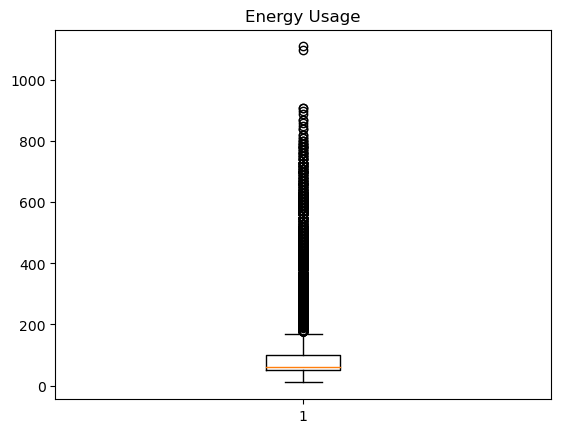

In [358]:
# display boxplot for the target, energy usage, variable
plt.boxplot(energyUse_df["TARGET_energy"])
plt.title("Energy Usage")
plt.show()

After displaying the boxplot for the target variable, it is observed that there are a number of outliers above the lower limit. These values will be dropped as to prevent these dramatically different values from affecting the model. The outliers are dropped using the IQR method.


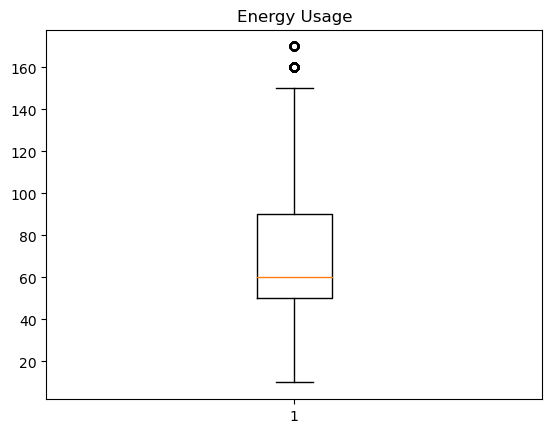

In [359]:
# get the quantiles and IQR
q1 = energyUse_df["TARGET_energy"].quantile(0.25)
q3 = energyUse_df["TARGET_energy"].quantile(0.75)
IQR = q3 - q1

# calculate lower and upper limits
lowerLimit = q1 - (1.5 * IQR)
upperLimit = q3 + (1.5 * IQR)

# get rid of rows with outliers from the dataframe
energyUse_df = energyUse_df.loc[
    (energyUse_df["TARGET_energy"] > lowerLimit)
    & (energyUse_df["TARGET_energy"] < upperLimit)
]

# display boxplot without outliers
plt.boxplot(energyUse_df["TARGET_energy"])
plt.title("Energy Usage")
plt.show()

In [360]:
energyUse_df.shape

(17525, 28)

# Relationship between variables

Using scatterplots, the relationship between the target variable, Energy Usage, against the other attributes in the dataframe is explored.


In [361]:


# plot scatterplots for all features against target variable
plt.figure(figsize=(20, 20))
for i, column in enumerate(columns):
    plt.subplot(6, 5, i + 1)
    sns.scatterplot(data=energyUse_df, x=column, y="TARGET_energy")
    plt.title(column)

plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

In [362]:
# # get list of columns other than date and target
# columns = (energyUse_df.columns).difference(["date", "TARGET_energy"])

# g = sns.PairGrid(data=energyUse_df, vars=columns, hue="TARGET_energy")
# g.map(sns.scatterplot)
# plt.show()

> **Observations:**
>
> - There are some plots that show that a linear decision boundary may be able to separate the two classes. eg.
> - Whereas there are some plots that show that a non-linear decision boundary may be to separate the two classes.


In [363]:
# get df without date column
energyUse_df_noDate = energyUse_df.drop(columns=["date"])

# plot correlation plot
f, ax = plt.subplots(figsize=(11, 9))
corr = energyUse_df_noDate.corr()
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")

[Text(0.5, 0, 'T1'),
 Text(1.5, 0, 'RH_1'),
 Text(2.5, 0, 'T2'),
 Text(3.5, 0, 'RH_2'),
 Text(4.5, 0, 'T3'),
 Text(5.5, 0, 'RH_3'),
 Text(6.5, 0, 'T4'),
 Text(7.5, 0, 'RH_4'),
 Text(8.5, 0, 'T5'),
 Text(9.5, 0, 'RH_5'),
 Text(10.5, 0, 'T6'),
 Text(11.5, 0, 'RH_6'),
 Text(12.5, 0, 'T7'),
 Text(13.5, 0, 'RH_7'),
 Text(14.5, 0, 'T8'),
 Text(15.5, 0, 'RH_8'),
 Text(16.5, 0, 'T9'),
 Text(17.5, 0, 'RH_9'),
 Text(18.5, 0, 'T_out'),
 Text(19.5, 0, 'Press_mm_hg'),
 Text(20.5, 0, 'RH_out'),
 Text(21.5, 0, 'Windspeed'),
 Text(22.5, 0, 'Visibility'),
 Text(23.5, 0, 'Tdewpoint'),
 Text(24.5, 0, 'rv1'),
 Text(25.5, 0, 'rv2'),
 Text(26.5, 0, 'TARGET_energy')]

> **Observations:**
>
> - Variables relating to temperature are highly positively correlated with each other, and variables that are related to humidity are similarly, highly positively correlated with each other.
> - Variables involving temperature generally have either a slight positive, or slight negative correlation with variables involving humidity.
> - RH_6, the humidity outside the building (northside) seems to be quite negatively correlated with variables regarding temperature.
> - The two random variables do not seem to be correlated with any other variable other being highly correlated with themselves as well as each other.


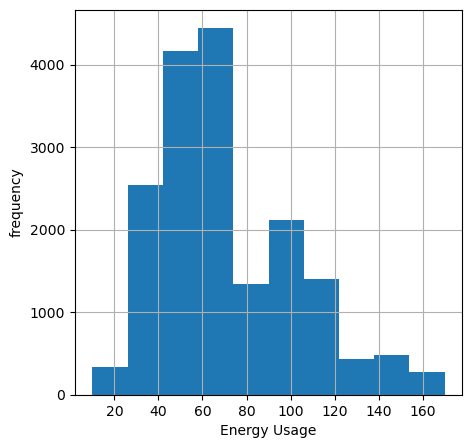

In [364]:
energyUse_df["TARGET_energy"].hist(figsize=(5, 5))
plt.xlabel("Energy Usage")
plt.ylabel("frequency")
plt.show()

# Creating Neural Network


In [388]:
# function to plot learning curve
def plot_learning_curve(
    train_loss, val_loss, train_metric, val_metric, metric_name="MeanAbsoluteError"
):

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, "r--")
    plt.plot(val_loss, "b--")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(["train", "val"], loc="upper left")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_metric, "r--")
    plt.plot(val_metric, "b--")
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(["train", "val"], loc="upper left")


    plt.show()
# function for residual plot
def plot_residuals(model, val_y, y_pred):
    residuals = val_y - y_pred

    fig, ax = plt.subplots()
    ax.scatter(val_y, residuals, s=25, zorder=10)

    ax.axhline(y=0, color="k", linestyle="-", linewidth=1, alpha=0.75, zorder=0)

    plt.xlabel("Energy Usage")
    plt.ylabel("Residuals")
    plt.title(f"Residuals Plot for {model}")
    plt.grid(True)
    plt.show()

    #function to crate scatter plot
def scatter_plot(val_y, y_pred, model):
    plt.scatter(val_y, y_pred)
    plt.xlabel("Actual Energy Usage")
    plt.ylabel("Predicted Energy Usage")
    plt.title(f"Actual vs Predicted Energy Usage for {model}")
    #red line
    plt.plot([val_y.min(), val_y.max()], [val_y.min(), val_y.max()], "r--")
    plt.show()

    #function to calculate and print metrics
def calculate_metrics(model, val_y, y_pred):
    r2 = r2_score(val_y, y_pred)
    rmse = np.sqrt(mean_squared_error(val_y, y_pred))
    mae = mean_absolute_error(val_y, y_pred)

    print(f"R2 Score for {model}: {r2}")
    print(f"Root Mean Squared Error for {model}: {rmse}")
    print(f"Mean Absolute Error for {model}: {mae}")


In [426]:
# split the data into traing, testing and validation

with pd.option_context("mode.chained_assignment", None):
    train_data, test_data = train_test_split(
        energyUse_df, test_size=0.3, shuffle=True, random_state=42
    )
    test_data, val_data = train_test_split(
        test_data, test_size=0.5, shuffle=True, random_state=42
    )

# remove the target column from the data
X_train = train_data.drop(columns=["TARGET_energy", "date"])
y_train = train_data["TARGET_energy"]

X_test = test_data.drop(columns=["TARGET_energy", "date"])
y_test = test_data["TARGET_energy"]

X_val = val_data.drop(columns=["TARGET_energy", "date"])
y_val = val_data["TARGET_energy"]

# train data - used to train the model
# validation data - used to tune the hyperparameters
# test data - used to evaluate the final model

# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (12267, 32)
y_train shape:  (12267,)
X_val shape:  (2629, 32)
y_val shape:  (2629,)
X_test shape:  (2629, 32)
y_test shape:  (2629,)


## Base Neural Network on unchanged Data


In [427]:
# base model values
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation="linear"),
    ]
)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# compile model
model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1
)

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_477 (Dense)           (None, 256)               8448      
                                                                 
 dense_478 (Dense)           (None, 1)                 257       
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 192346.9219 - mean_absolute_error: 117.0228 - val_loss: 858.9838 - val_mean_absolute_error: 22.3780
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 797.7065 - mean_absolute_error: 21.1686 - val_loss: 708.5143 - val_mean_absolute_error: 19.8976
Epoch 3/50
384/384 [==============================] - 1s 3ms/step - loss: 863.4258 - mean_absolute_err

In [428]:
# plot learning curve
plot_learning_curve(
    history.history["loss"],
    history.history["val_loss"],
    history.history["mean_absolute_error"],
    history.history["val_mean_absolute_error"],
)
#plot residual plot
y_pred = model.predict(X_val)
y_pred = y_pred.flatten()
plot_residuals("Base Model", y_val, y_pred)

#scatter plot
scatter_plot(y_val, y_pred, "Base Model")

#calculate metrics
calculate_metrics("Base Model", y_val, y_pred)

83/83 [==============================] - 0s 2ms/step


R2 Score for Base Model: -1.192666828097824
Root Mean Squared Error for Base Model: 44.42635320989492
Mean Absolute Error for Base Model: 32.46818331496123


#### Observations

- the model performs extremely poorly
- neds significant improvement
  -over fitting is a major issue


In [429]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [430]:

model2 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ]
)

model2.summary()
tf.keras.utils.plot_model(model2, show_shapes=True)


# compile model
model2.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history2 = model2.fit(
    X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, verbose=1
)

Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_479 (Dense)           (None, 256)               8448      
                                                                 
 dense_480 (Dense)           (None, 1)                 257       
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
384/384 [==============================] - 2s 5ms/step - loss: 2549.2190 - mean_absolute_error: 39.9470 - val_loss: 998.6569 - val_mean_absolute_error: 24.2476
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 859.0566 - mean_absolute_error: 22.1591 - val_loss: 723.2818 - val_mean_absolute_error: 20.1488
Epoch 3/50
384/384 [==============================] - 2s 4ms/step - loss: 683.5793 - mean_absolute_error:

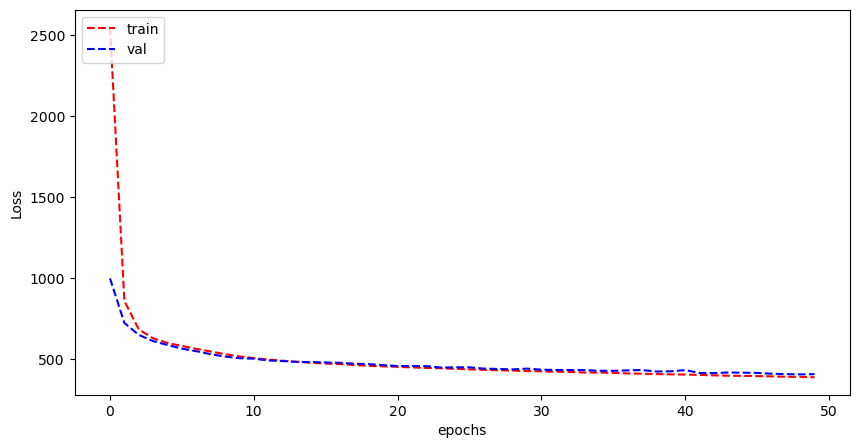

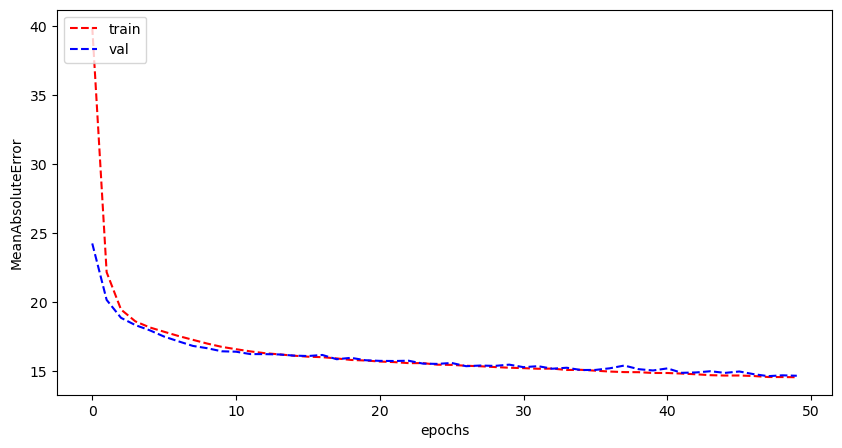

83/83 [==============================] - 0s 2ms/step


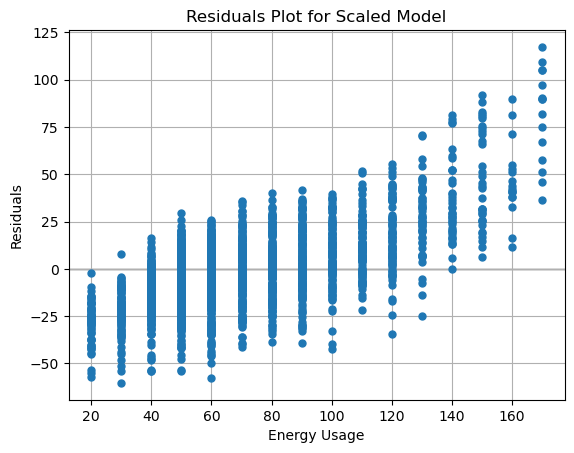

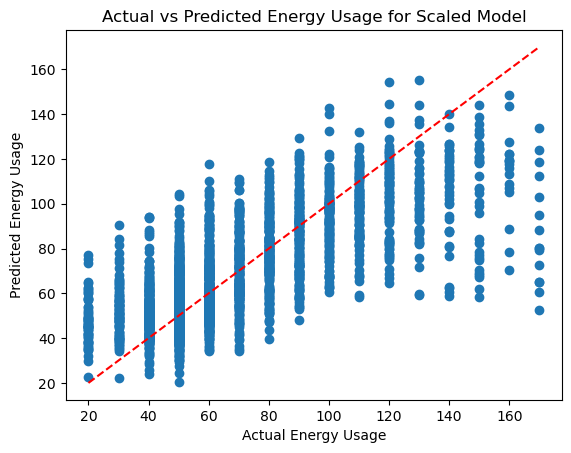

R2 Score for Scaled Model: 0.5476001700795435
Root Mean Squared Error for Scaled Model: 20.179739629121233
Mean Absolute Error for Scaled Model: 14.640119033151818


In [431]:
# plot learning curve
plot_learning_curve(
    history2.history["loss"],
    history2.history["val_loss"],
    history2.history["mean_absolute_error"],
    history2.history["val_mean_absolute_error"],
)

#plot residual plot
y_pred = model2.predict(X_val_scaled)
y_pred = y_pred.flatten()
plot_residuals("Scaled Model", y_val, y_pred)

#scatter plot
scatter_plot(y_val, y_pred, "Scaled Model")

#calculate metrics
calculate_metrics("Scaled Model", y_val, y_pred)


- still seems to be overfitting possibly


In [432]:
# change batchsize

INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 64

# create model
model3 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ]
)

# compile model
model3.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history3 = model3.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
192/192 [==============================] - 1s 4ms/step - loss: 3702.4812 - mean_absolute_error: 51.3169 - val_loss: 1567.6240 - val_mean_absolute_error: 30.5753
Epoch 2/50
192/192 [==============================] - 1s 3ms/step - loss: 1265.4873 - mean_absolute_error: 27.5168 - val_loss: 979.6844 - val_mean_absolute_error: 24.0370
Epoch 3/50
192/192 [==============================] - 0s 2ms/step - loss: 906.9420 - mean_absolute_error: 22.8838 - val_loss: 788.9144 - val_mean_absolute_error: 21.1108
Epoch 4/50
192/192 [==============================] - 0s 2ms/step - loss: 752.8438 - mean_absolute_error: 20.5160 - val_loss: 699.1083 - val_mean_absolute_error: 19.5513
Epoch 5/50
192/192 [==============================] - 1s 3ms/step - loss: 679.6684 - mean_absolute_error: 19.3762 - val_loss: 657.8851 - val_mean_absolute_error: 19.0484
Epoch 6/50
192/192 [==============================] - 0s 3ms/step - loss: 643.5497 - mean_absolute_error: 18.8491 - val_loss: 627.4473 - val_mean_a

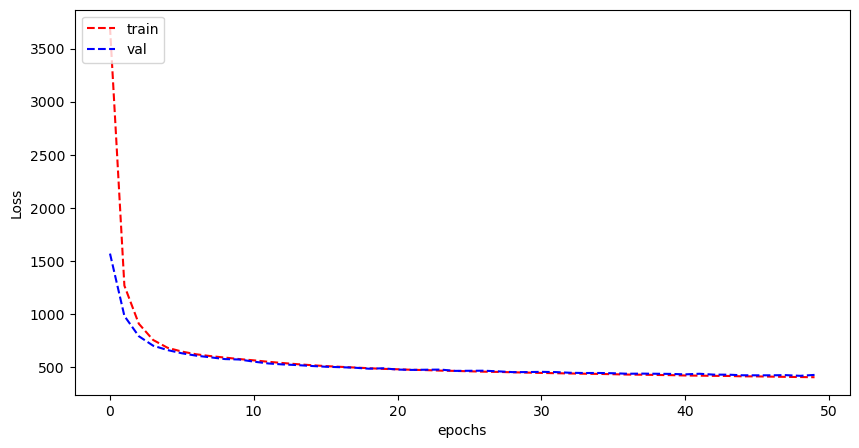

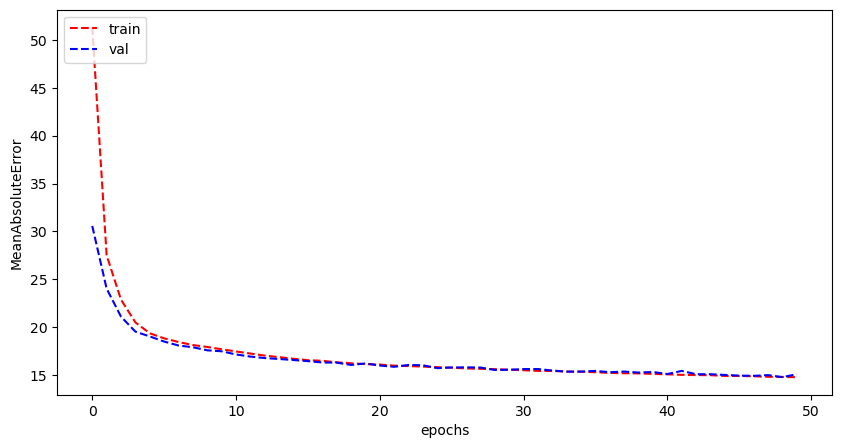

83/83 [==============================] - 0s 951us/step


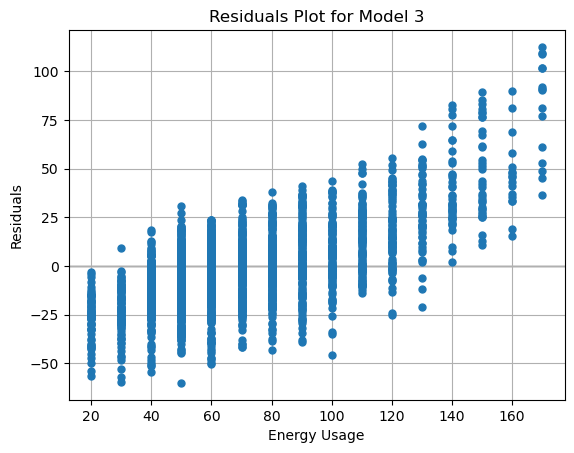

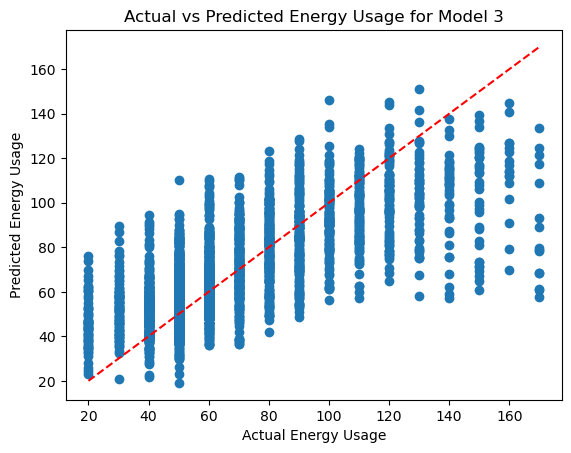

R2 Score for Model 3: 0.5294236928712095
Root Mean Squared Error for Model 3: 20.581137330270884
Mean Absolute Error for Model 3: 15.105334248910978


In [433]:
# plot learning curve
plot_learning_curve(
    history3.history["loss"],
    history3.history["val_loss"],
    history3.history["mean_absolute_error"],
    history3.history["val_mean_absolute_error"],
)

# plot residual plot
y_pred = model3.predict(X_val_scaled)
y_pred = y_pred.flatten()
plot_residuals("Model 3", y_val, y_pred)

# scatter plot
scatter_plot(y_val, y_pred, "Model 3")

# calculate metrics
calculate_metrics("Model 3", y_val, y_pred)

Model is overfitting


In [434]:
# try regularisation
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 128

# create model
model4 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l1(0.01),
        ),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model4.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
)

# train the model
history5 = model4.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
96/96 [==============================] - 1s 5ms/step - loss: 3656.2500 - mean_absolute_error: 50.5830 - val_loss: 1732.1044 - val_mean_absolute_error: 31.2263
Epoch 2/50
96/96 [==============================] - 0s 3ms/step - loss: 1341.2885 - mean_absolute_error: 27.2983 - val_loss: 1055.0238 - val_mean_absolute_error: 24.3713
Epoch 3/50
96/96 [==============================] - 0s 3ms/step - loss: 987.0229 - mean_absolute_error: 23.3615 - val_loss: 872.4805 - val_mean_absolute_error: 21.9038
Epoch 4/50
96/96 [==============================] - 0s 3ms/step - loss: 848.4250 - mean_absolute_error: 21.3092 - val_loss: 792.7035 - val_mean_absolute_error: 20.5851
Epoch 5/50
96/96 [==============================] - 0s 3ms/step - loss: 775.9815 - mean_absolute_error: 20.2252 - val_loss: 748.1520 - val_mean_absolute_error: 19.8474
Epoch 6/50
96/96 [==============================] - 0s 4ms/step - loss: 732.9089 - mean_absolute_error: 19.5882 - val_loss: 715.2131 - val_mean_absolute_err

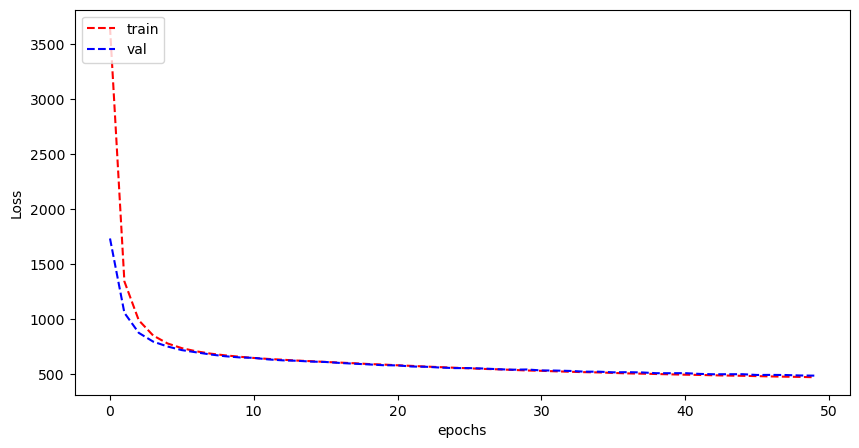

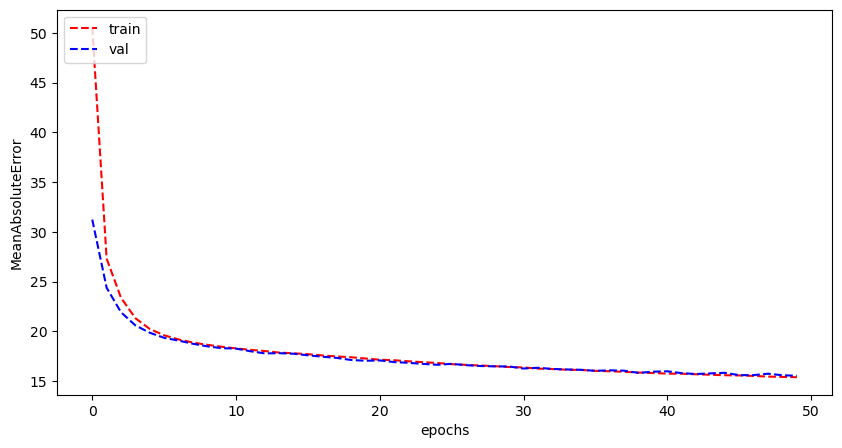

83/83 [==============================] - 0s 1ms/step


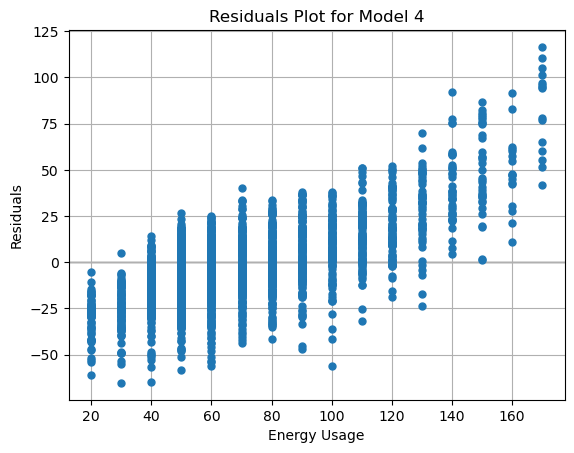

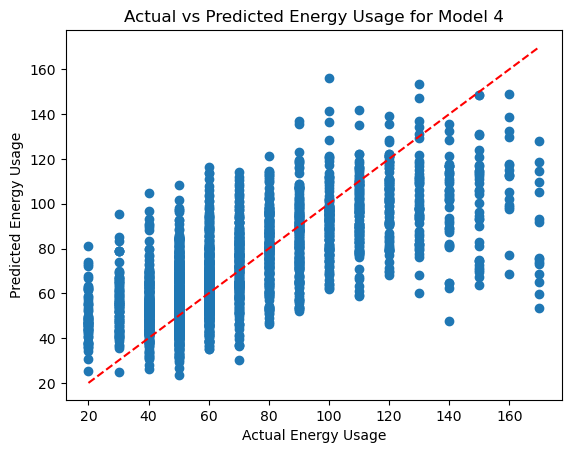

R2 Score for Model 4: 0.5013738803498232
Root Mean Squared Error for Model 4: 21.18565297507751
Mean Absolute Error for Model 4: 15.518203191223957


In [435]:
# plot learning curve
plot_learning_curve(
    history5.history["loss"],
    history5.history["val_loss"],
    history5.history["mean_absolute_error"],
    history5.history["val_mean_absolute_error"],
)

# plot residual plot
y_pred = model4.predict(X_val_scaled)
y_pred = y_pred.flatten()
plot_residuals("Model 4", y_val, y_pred)

# scatter plot
scatter_plot(y_val, y_pred, "Model 4")

# calculate metrics
calculate_metrics("Model 4", y_val, y_pred)

- still overfitting the model   
-standard scaler is working better than minmax scaler

In [436]:
# tune regularisation
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 128
REGULARIZATIONFACTOR = 5

# create model
model5 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model5.compile(
    optimizer="adam",
    loss='mean_squared_error',
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history6 = model5.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
96/96 [==============================] - 7s 5ms/step - loss: 8161.1050 - mean_absolute_error: 56.0378 - root_mean_squared_error: 64.5594 - val_loss: 5635.4644 - val_mean_absolute_error: 40.2006 - val_root_mean_squared_error: 49.7153
Epoch 2/50
96/96 [==============================] - 0s 3ms/step - loss: 4428.6670 - mean_absolute_error: 32.5723 - root_mean_squared_error: 42.7377 - val_loss: 3335.4675 - val_mean_absolute_error: 27.2856 - val_root_mean_squared_error: 36.1667
Epoch 3/50
96/96 [==============================] - 0s 3ms/step - loss: 2788.6555 - mean_absolute_error: 25.9290 - root_mean_squared_error: 34.6951 - val_loss: 2205.3242 - val_mean_absolute_error: 23.7149 - val_root_mean_squared_error: 31.7463
Epoch 4/50
96/96 [==============================] - 0s 3ms/step - loss: 1889.4510 - mean_absolute_error: 22.8968 - root_mean_squared_error: 30.8562 - val_loss: 1527.7891 - val_mean_absolute_error: 21.0982 - val_root_mean_squared_error: 28.7443
Epoch 5/50
96/96 [======

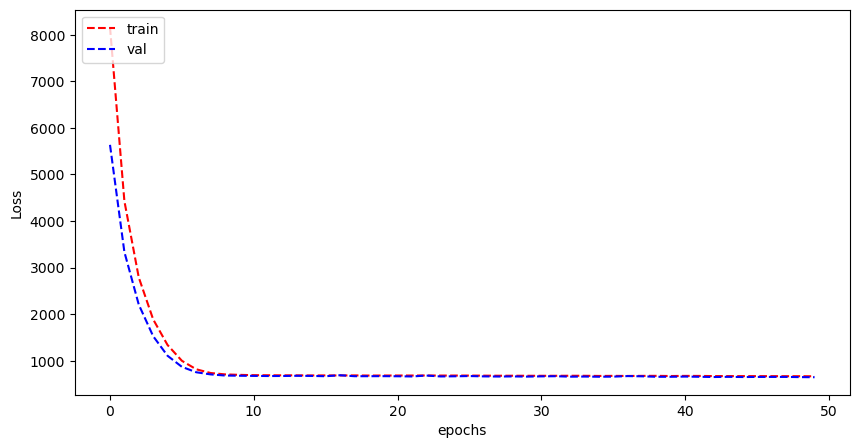

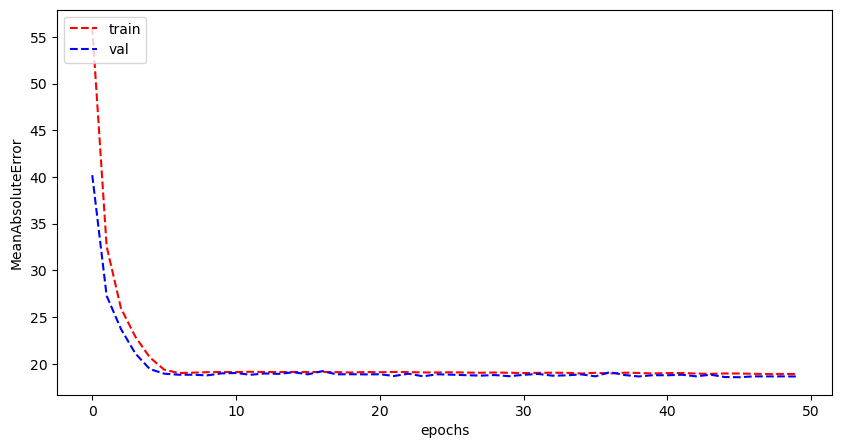

83/83 [==============================] - 0s 2ms/step


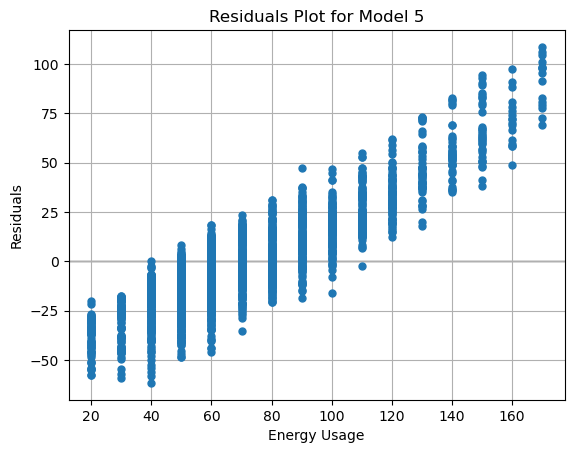

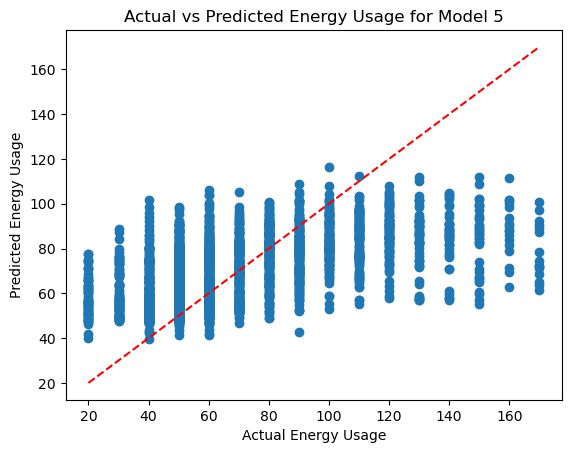

R2 Score for Model 5: 0.31177233055108955
Root Mean Squared Error for Model 5: 24.889742662108404
Mean Absolute Error for Model 5: 18.64043811030513


In [437]:
# plot learning curve
plot_learning_curve(
    history6.history["loss"],
    history6.history["val_loss"],
    history6.history["mean_absolute_error"],
    history6.history["val_mean_absolute_error"],
)

# plot residual plot
y_pred = model5.predict(X_val_scaled)
y_pred = y_pred.flatten()
plot_residuals("Model 5", y_val, y_pred)

# scatter plot
scatter_plot(y_val, y_pred, "Model 5")

# calculate metrics
calculate_metrics("Model 5", y_val, y_pred)

- not greatv still but no more overfitting 

# MODEL 6 - Scaled Data, L2 Regularisation, DropOut and Batch Normalization


In [438]:

# tune regularisation
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 64
REGULARIZATIONFACTOR = 0.01

# create model
model6 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(0.5),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model6.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history7 = model6.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
192/192 [==============================] - 2s 5ms/step - loss: 5096.1777 - mean_absolute_error: 65.3423 - root_mean_squared_error: 71.3519 - val_loss: 3688.1528 - val_mean_absolute_error: 55.0508 - val_root_mean_squared_error: 60.6889
Epoch 2/50
192/192 [==============================] - 1s 6ms/step - loss: 2032.0205 - mean_absolute_error: 37.1209 - root_mean_squared_error: 45.0226 - val_loss: 821.2571 - val_mean_absolute_error: 21.4163 - val_root_mean_squared_error: 28.5707
Epoch 3/50
192/192 [==============================] - 1s 3ms/step - loss: 672.5031 - mean_absolute_error: 19.0855 - root_mean_squared_error: 25.8367 - val_loss: 549.6697 - val_mean_absolute_error: 17.1649 - val_root_mean_squared_error: 23.3389
Epoch 4/50
192/192 [==============================] - 1s 4ms/step - loss: 602.1138 - mean_absolute_error: 18.3333 - root_mean_squared_error: 24.4366 - val_loss: 533.2111 - val_mean_absolute_error: 16.9589 - val_root_mean_squared_error: 22.9835
Epoch 5/50
192/192 [=

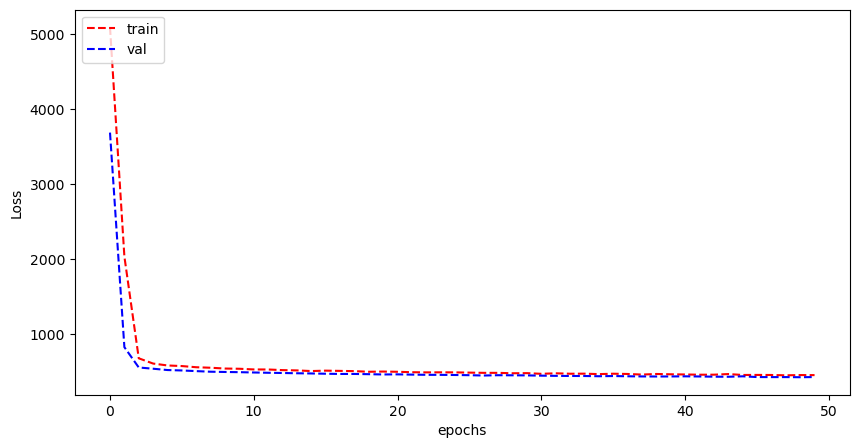

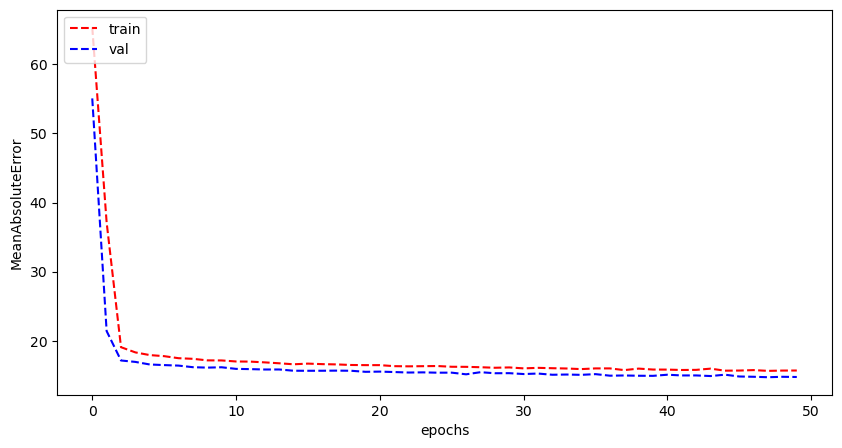

83/83 [==============================] - 0s 1ms/step


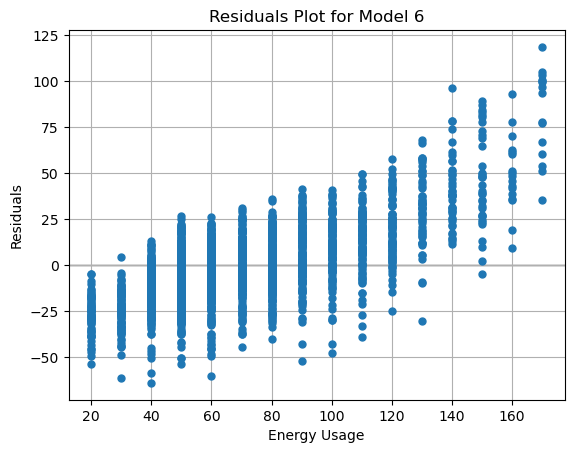

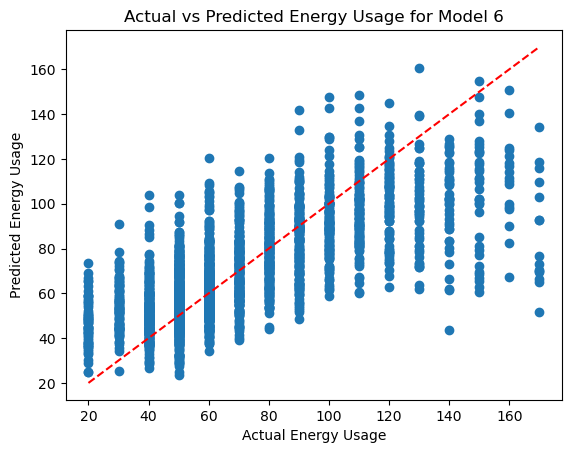

R2 Score for Model 6: 0.5364967228003918
Root Mean Squared Error for Model 6: 20.425878606254642
Mean Absolute Error for Model 6: 14.778801045611857


In [439]:
# plot learning curve
plot_learning_curve(
    history7.history["loss"],
    history7.history["val_loss"],
    history7.history["mean_absolute_error"],
    history7.history["val_mean_absolute_error"],
)



# residual plot
y_pred = model6.predict(X_val_scaled)
y_pred = y_pred.flatten()
plot_residuals("Model 6", y_val, y_pred)

# scatter plot
scatter_plot(y_val, y_pred, "Model 6")

# calculate metrics
calculate_metrics("Model 6", y_val, y_pred)

- performing not well but better thasn the start
- will try creatting features to represent the time series data

In [440]:
# create time based features
energyUse_df["date"] = pd.to_datetime(energyUse_df["date"], format="%Y-%m-%d %H:%M:%S")
# create time-based features
energyUse_df['hour'] = energyUse_df['date'].dt.hour
energyUse_df['day'] = energyUse_df['date'].dt.day
energyUse_df['month'] = energyUse_df['date'].dt.month
energyUse_df['year'] = energyUse_df['date'].dt.year

# drop rows with missing values
energyUse_df = energyUse_df.dropna()

# resplit the data
train_data, test_data = train_test_split(energyUse_df, test_size=0.3, shuffle=True, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=42)

# remove the target column from the data
X_train = train_data.drop(columns=["TARGET_energy", "date"])
y_train = train_data["TARGET_energy"]

X_test = test_data.drop(columns=["TARGET_energy", "date"])
y_test = test_data["TARGET_energy"]

X_val = val_data.drop(columns=["TARGET_energy", "date"])
y_val = val_data["TARGET_energy"]

# train data - used to train the model
# validation data - used to tune the hyperparameters
# test data - used to evaluate the final model

# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (12267, 32)
y_train shape:  (12267,)
X_val shape:  (2629, 32)
y_val shape:  (2629,)
X_test shape:  (2629, 32)
y_test shape:  (2629,)


In [441]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [442]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 256  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 64
REGULARIZATIONFACTOR = 0.01

# create model
model7 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(0.5),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model7.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history8 = model7.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
192/192 [==============================] - 2s 6ms/step - loss: 5070.0249 - mean_absolute_error: 65.1877 - root_mean_squared_error: 71.1694 - val_loss: 3614.0212 - val_mean_absolute_error: 54.3767 - val_root_mean_squared_error: 60.0763
Epoch 2/50
192/192 [==============================] - 1s 3ms/step - loss: 2000.8779 - mean_absolute_error: 36.5716 - root_mean_squared_error: 44.6771 - val_loss: 827.1671 - val_mean_absolute_error: 21.3133 - val_root_mean_squared_error: 28.6765
Epoch 3/50
192/192 [==============================] - 1s 4ms/step - loss: 670.2533 - mean_absolute_error: 18.9692 - root_mean_squared_error: 25.7960 - val_loss: 550.1524 - val_mean_absolute_error: 17.1578 - val_root_mean_squared_error: 23.3524
Epoch 4/50
192/192 [==============================] - 1s 3ms/step - loss: 598.8515 - mean_absolute_error: 18.2403 - root_mean_squared_error: 24.3729 - val_loss: 529.2192 - val_mean_absolute_error: 16.8110 - val_root_mean_squared_error: 22.8999
Epoch 5/50
192/192 [=

In [443]:
#power transform data
scaler = PowerTransformer(method='yeo-johnson').fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)



In [444]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512  # this can be tuned later
OUTPUT_CLASSES = 1
BATCH_SIZE = 128
REGULARIZATIONFACTOR = 0.05

# create model
model8 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(0.5),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(0.5),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model8.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history9 = model8.fit(
    X_train_transformed,
    y_train,
    validation_data=(X_val_transformed, y_val),
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
)

Epoch 1/50
96/96 [==============================] - 2s 12ms/step - loss: 5404.8828 - mean_absolute_error: 67.7077 - root_mean_squared_error: 72.8470 - val_loss: 5101.7397 - val_mean_absolute_error: 66.2684 - val_root_mean_squared_error: 70.7570
Epoch 2/50
96/96 [==============================] - 1s 9ms/step - loss: 3470.0588 - mean_absolute_error: 52.0954 - root_mean_squared_error: 58.1029 - val_loss: 2308.0786 - val_mean_absolute_error: 41.4778 - val_root_mean_squared_error: 47.0584
Epoch 3/50
96/96 [==============================] - 1s 9ms/step - loss: 1320.6552 - mean_absolute_error: 27.4861 - root_mean_squared_error: 35.0309 - val_loss: 744.3512 - val_mean_absolute_error: 18.5603 - val_root_mean_squared_error: 25.5126
Epoch 4/50
96/96 [==============================] - 1s 10ms/step - loss: 710.6005 - mean_absolute_error: 18.3126 - root_mean_squared_error: 24.8429 - val_loss: 586.1990 - val_mean_absolute_error: 15.8082 - val_root_mean_squared_error: 22.1996
Epoch 5/50
96/96 [=======

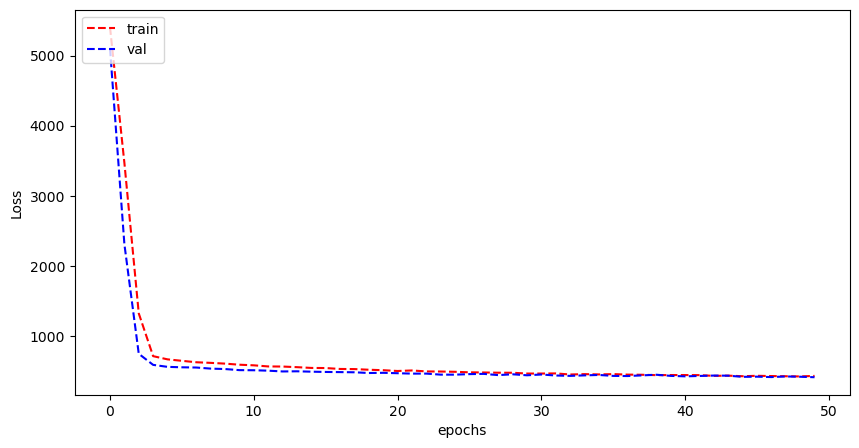

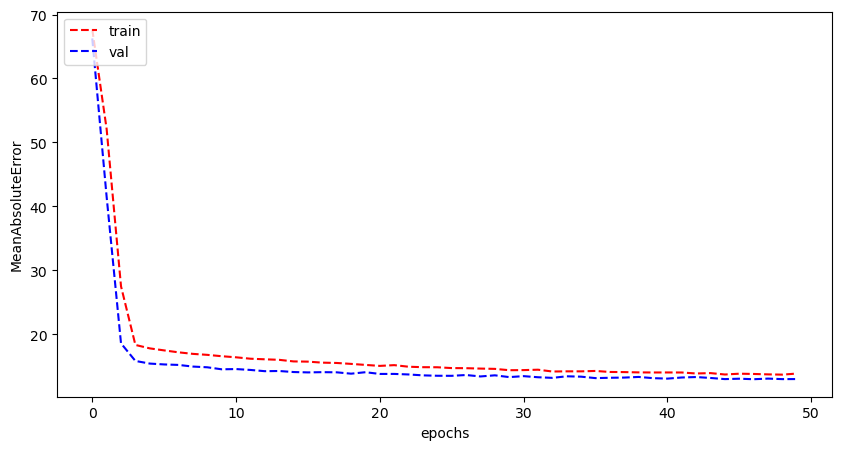

83/83 [==============================] - 0s 2ms/step


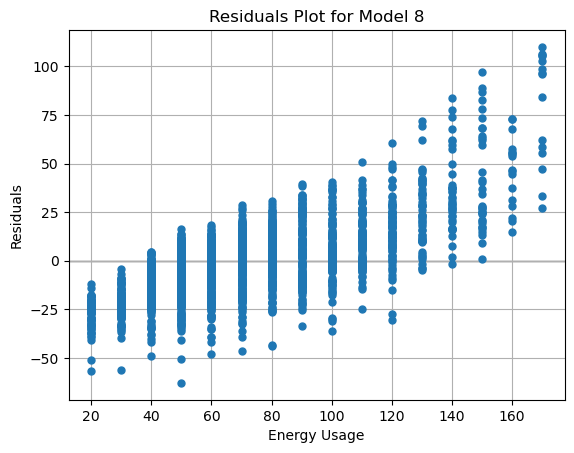

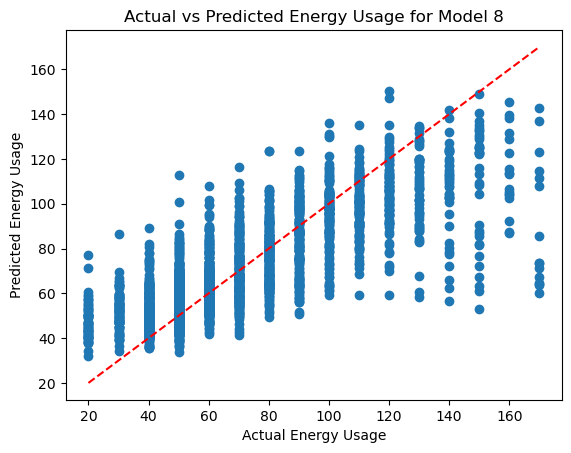

R2 Score for Model 8: 0.6275700855914275
Root Mean Squared Error for Model 8: 18.30950572871135
Mean Absolute Error for Model 8: 12.971442719202344


In [445]:
#plot learning curve
plot_learning_curve(
    history9.history["loss"],
    history9.history["val_loss"],
    history9.history["mean_absolute_error"],
    history9.history["val_mean_absolute_error"],
)

    #plot residual plot
y_pred = model8.predict(X_val_transformed)
y_pred = y_pred.flatten()
plot_residuals("Model 8", y_val, y_pred)

#scatter plot
scatter_plot(y_val, y_pred, "Model 8")

#calculate metrics
calculate_metrics("Model 8", y_val, y_pred)


In [446]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM =    512
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
REGULARIZATIONFACTOR = 0.015
DROPOUT = 0.5
learningrate = 0.001
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=10)

# create model
model9 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),

        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model9.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history10 = model9.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
48/48 - 3s - loss: 5611.3267 - mean_absolute_error: 69.4278 - root_mean_squared_error: 74.7045 - val_loss: 6137.8823 - val_mean_absolute_error: 73.5017 - val_root_mean_squared_error: 78.1503 - lr: 0.0010 - 3s/epoch - 61ms/step
Epoch 2/100
48/48 - 1s - loss: 4967.4634 - mean_absolute_error: 65.4870 - root_mean_squared_error: 70.2649 - val_loss: 5127.6294 - val_mean_absolute_error: 67.2747 - val_root_mean_squared_error: 71.3960 - lr: 0.0010 - 633ms/epoch - 13ms/step
Epoch 3/100
48/48 - 1s - loss: 3882.1367 - mean_absolute_error: 57.0437 - root_mean_squared_error: 62.0635 - val_loss: 3650.2339 - val_mean_absolute_error: 55.6466 - val_root_mean_squared_error: 60.1658 - lr: 0.0010 - 692ms/epoch - 14ms/step
Epoch 4/100
48/48 - 1s - loss: 2545.3584 - mean_absolute_error: 44.1830 - root_mean_squared_error: 50.1494 - val_loss: 2001.9486 - val_mean_absolute_error: 38.7607 - val_root_mean_squared_error: 44.4011 - lr: 0.0010 - 737ms/epoch - 15ms/step
Epoch 5/100
48/48 - 1s - loss: 1426

moidel is overfitting - parameter tuning required

In [447]:
#Further tuning of model parameters
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model10 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model10.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history11 = model10.fit(
    X_train_transformed,
    y_train,
    validation_data=(X_val_transformed, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
24/24 - 3s - loss: 5744.6177 - mean_absolute_error: 69.7829 - root_mean_squared_error: 75.2398 - val_loss: 9951.7158 - val_mean_absolute_error: 90.6131 - val_root_mean_squared_error: 99.3422 - lr: 0.0015 - 3s/epoch - 144ms/step
Epoch 2/100
24/24 - 1s - loss: 5325.0400 - mean_absolute_error: 67.6234 - root_mean_squared_error: 72.4081 - val_loss: 6016.3701 - val_mean_absolute_error: 72.1544 - val_root_mean_squared_error: 77.0392 - lr: 0.0015 - 700ms/epoch - 29ms/step
Epoch 3/100
24/24 - 1s - loss: 4737.0186 - mean_absolute_error: 63.4525 - root_mean_squared_error: 68.2355 - val_loss: 4594.4160 - val_mean_absolute_error: 63.0632 - val_root_mean_squared_error: 67.1845 - lr: 0.0015 - 784ms/epoch - 33ms/step
Epoch 4/100
24/24 - 1s - loss: 3856.0007 - mean_absolute_error: 56.3472 - root_mean_squared_error: 61.4442 - val_loss: 3579.7300 - val_mean_absolute_error: 54.5512 - val_root_mean_squared_error: 59.1532 - lr: 0.0015 - 793ms/epoch - 33ms/step
Epoch 5/100
24/24 - 1s - loss: 283

83/83 [==============================] - 1s 3ms/step


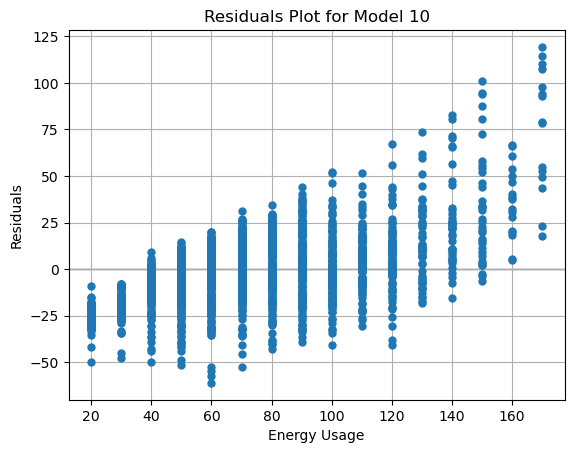

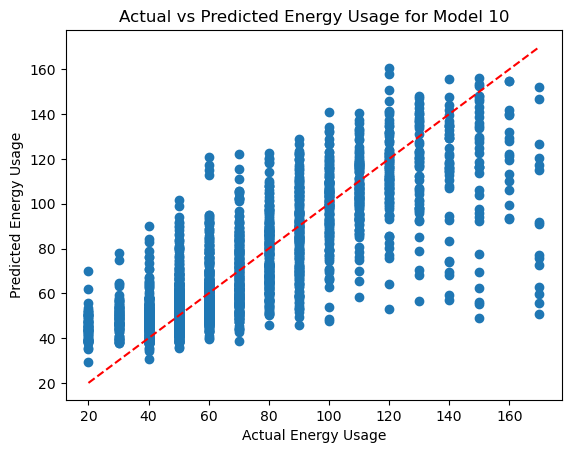

R2 Score for Model 10: 0.6570150200283555
Root Mean Squared Error for Model 10: 17.570814460297097
Mean Absolute Error for Model 10: 12.252210342825117


In [448]:
# r2 score
# Generate predictions
y_val_pred = model10.predict(X_val_transformed)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

#residual plot
plot_residuals("Model 10", y_val, y_val_pred)

#scatter plot
scatter_plot(y_val, y_val_pred, "Model 10")

#calculate metrics
calculate_metrics("Model 10", y_val, y_val_pred)


In [449]:
# drop rh6
X_train= X_train.drop(columns=["RH_6"])
X_val = X_val.drop(columns=["RH_6"])
X_test = X_test.drop(columns=["RH_6"])
# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
#standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)


In [450]:

INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model11 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model11.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history12 = model11.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
24/24 - 5s - loss: 5747.3027 - mean_absolute_error: 69.7815 - root_mean_squared_error: 75.2566 - val_loss: 8172.1924 - val_mean_absolute_error: 81.5672 - val_root_mean_squared_error: 89.9398 - lr: 0.0015 - 5s/epoch - 190ms/step
Epoch 2/100
24/24 - 1s - loss: 5325.7793 - mean_absolute_error: 67.6417 - root_mean_squared_error: 72.4120 - val_loss: 5809.8867 - val_mean_absolute_error: 70.6535 - val_root_mean_squared_error: 75.6863 - lr: 0.0015 - 809ms/epoch - 34ms/step
Epoch 3/100
24/24 - 1s - loss: 4740.4902 - mean_absolute_error: 63.4957 - root_mean_squared_error: 68.2602 - val_loss: 4532.9512 - val_mean_absolute_error: 62.4502 - val_root_mean_squared_error: 66.7247 - lr: 0.0015 - 807ms/epoch - 34ms/step
Epoch 4/100
24/24 - 1s - loss: 3868.8989 - mean_absolute_error: 56.4278 - root_mean_squared_error: 61.5483 - val_loss: 3329.2698 - val_mean_absolute_error: 52.3216 - val_root_mean_squared_error: 56.9960 - lr: 0.0015 - 831ms/epoch - 35ms/step
Epoch 5/100
24/24 - 1s - loss: 284

83/83 [==============================] - 0s 2ms/step
R2 score: 0.6536177740635745


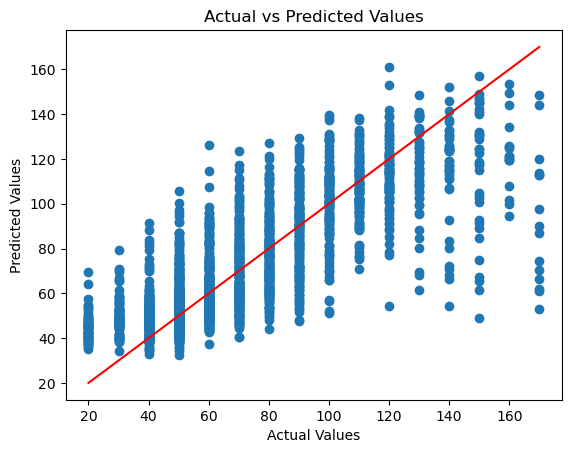

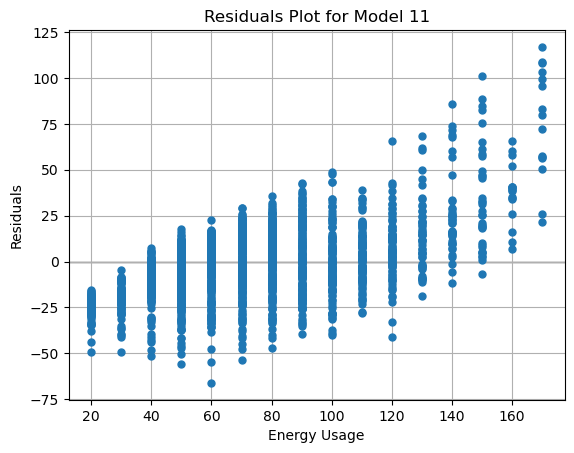

In [451]:
# r2 score
# Generate predictions
y_val_pred = model11.predict(X_val_transformed)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

#residual plot
plot_residuals("Model 11", y_val, y_val_pred)

In [452]:
# drop t6
X_train = X_train.drop(columns=["T6"])
X_val = X_val.drop(columns=["T6"])
X_test = X_test.drop(columns=["T6"])
# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
# standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)

In [453]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model12 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model12.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history13 = model12.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
24/24 - 3s - loss: 5729.3530 - mean_absolute_error: 69.7681 - root_mean_squared_error: 75.1377 - val_loss: 8716.9004 - val_mean_absolute_error: 84.1843 - val_root_mean_squared_error: 92.9184 - lr: 0.0015 - 3s/epoch - 144ms/step
Epoch 2/100
24/24 - 1s - loss: 5315.8706 - mean_absolute_error: 67.5939 - root_mean_squared_error: 72.3430 - val_loss: 5846.5151 - val_mean_absolute_error: 71.2439 - val_root_mean_squared_error: 75.9272 - lr: 0.0015 - 845ms/epoch - 35ms/step
Epoch 3/100
24/24 - 1s - loss: 4731.0913 - mean_absolute_error: 63.4564 - root_mean_squared_error: 68.1902 - val_loss: 4653.4561 - val_mean_absolute_error: 63.4964 - val_root_mean_squared_error: 67.6203 - lr: 0.0015 - 830ms/epoch - 35ms/step
Epoch 4/100
24/24 - 1s - loss: 3853.9817 - mean_absolute_error: 56.3506 - root_mean_squared_error: 61.4253 - val_loss: 3367.2590 - val_mean_absolute_error: 52.6844 - val_root_mean_squared_error: 57.3263 - lr: 0.0015 - 893ms/epoch - 37ms/step
Epoch 5/100
24/24 - 1s - loss: 283

83/83 [==============================] - 0s 2ms/step
R2 score: 0.6629862528955718
RMSE: 17.417192434212005
MAE: 12.245791670667577
MSE: 303.35859229037186


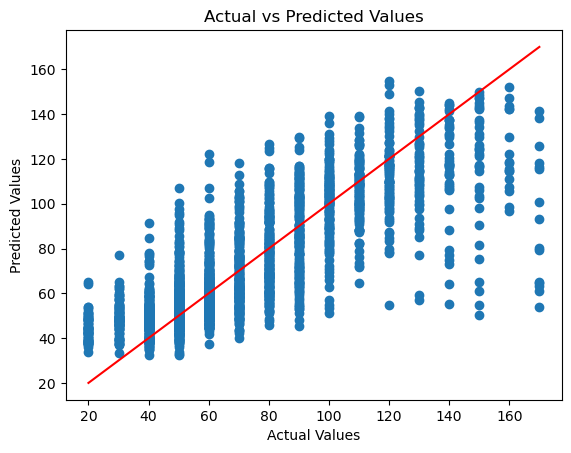

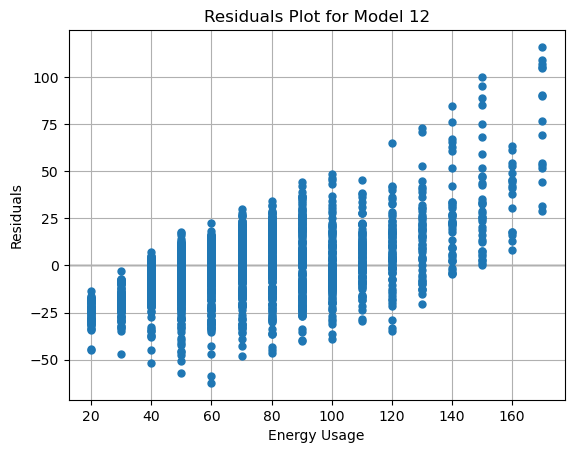

In [454]:
# r2 score

# Generate predictions
y_val_pred = model12.predict(X_val_transformedandscaled)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)


print(f"R2 score: {r2}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE: {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_val, y_val_pred)
print(f"MAE: {mae}")

# Calculate MSE (loss)
mse = mean_squared_error(y_val, y_val_pred)
print(f"MSE: {mse}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model 12", y_val, y_val_pred)

In [455]:
# add column for number of seconbnds from midnight
energyUse_df["date"] = pd.to_datetime(energyUse_df["date"])
energyUse_df["seconds_from_midnight"] = (
    energyUse_df["date"].dt.hour * 3600
    + energyUse_df["date"].dt.minute * 60
    + energyUse_df["date"].dt.second
)
#add column for day of the week
energyUse_df["day_of_week"] = energyUse_df["date"].dt.dayofweek

X_train = train_data.drop(columns=["TARGET_energy", "date"])
y_train = train_data["TARGET_energy"]


X_test = test_data.drop(columns=["TARGET_energy", "date"])
y_test = test_data["TARGET_energy"]

X_val = val_data.drop(columns=["TARGET_energy", "date"])
y_val = val_data["TARGET_energy"]

# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
# standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)

# train data - used to train the model
# validation data - used to tune the hyperparameters
# test data - used to evaluate the final model

# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (12267, 32)
y_train shape:  (12267,)
X_val shape:  (2629, 32)
y_val shape:  (2629,)
X_test shape:  (2629, 32)
y_test shape:  (2629,)


Epoch 1/100
24/24 - 3s - loss: 5748.2588 - mean_absolute_error: 69.7961 - root_mean_squared_error: 75.2681 - val_loss: 9194.1748 - val_mean_absolute_error: 87.3139 - val_root_mean_squared_error: 95.4569 - lr: 0.0015 - 3s/epoch - 115ms/step
Epoch 2/100
24/24 - 1s - loss: 5327.7422 - mean_absolute_error: 67.6488 - root_mean_squared_error: 72.4315 - val_loss: 6290.5332 - val_mean_absolute_error: 73.7078 - val_root_mean_squared_error: 78.8029 - lr: 0.0015 - 706ms/epoch - 29ms/step
Epoch 3/100
24/24 - 1s - loss: 4744.5117 - mean_absolute_error: 63.5438 - root_mean_squared_error: 68.2954 - val_loss: 4810.6709 - val_mean_absolute_error: 64.4721 - val_root_mean_squared_error: 68.7797 - lr: 0.0015 - 721ms/epoch - 30ms/step
Epoch 4/100
24/24 - 1s - loss: 3874.3318 - mean_absolute_error: 56.5250 - root_mean_squared_error: 61.5979 - val_loss: 3356.9509 - val_mean_absolute_error: 52.5892 - val_root_mean_squared_error: 57.2440 - lr: 0.0015 - 723ms/epoch - 30ms/step
Epoch 5/100
24/24 - 1s - loss: 285

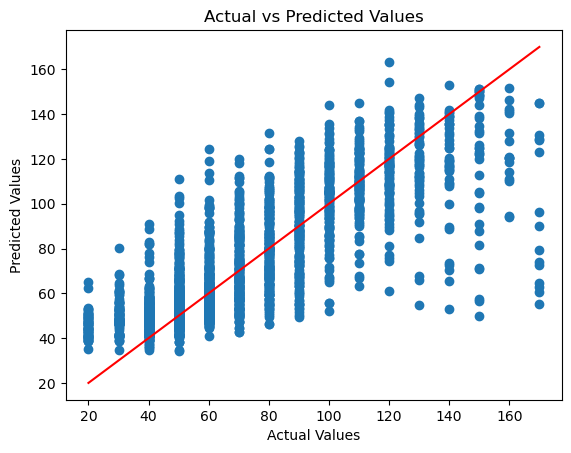

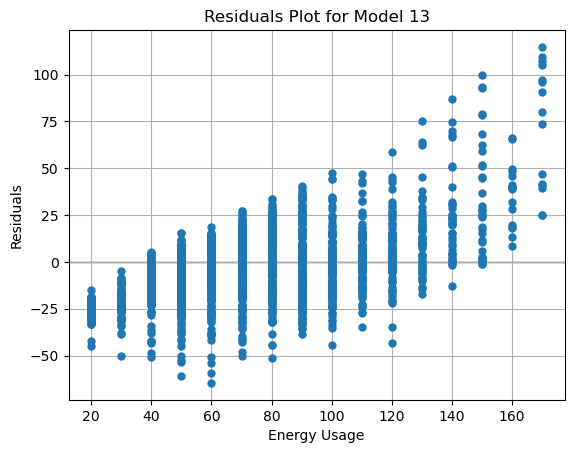

In [456]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model13 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model13.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history14 = model13.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

    # r2 score
# Generate predictions
y_val_pred = model13.predict(X_val_transformed)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model 13", y_val, y_val_pred)

In [457]:
# drop hour, day, month, year,
X_train = X_train.drop(columns=["hour", "day", "month", "year"])
X_val = X_val.drop(columns=["hour", "day", "month", "year"])
X_test = X_test.drop(columns=["hour", "day", "month", "year"])
# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
# standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)


Epoch 1/100
24/24 - 3s - loss: 5770.2974 - mean_absolute_error: 69.8144 - root_mean_squared_error: 75.4119 - val_loss: 7348.8999 - val_mean_absolute_error: 79.1309 - val_root_mean_squared_error: 85.2426 - lr: 0.0015 - 3s/epoch - 134ms/step
Epoch 2/100
24/24 - 1s - loss: 5326.8931 - mean_absolute_error: 67.6884 - root_mean_squared_error: 72.4218 - val_loss: 6076.4922 - val_mean_absolute_error: 71.9198 - val_root_mean_squared_error: 77.4287 - lr: 0.0015 - 682ms/epoch - 28ms/step
Epoch 3/100
24/24 - 1s - loss: 4755.8330 - mean_absolute_error: 63.5822 - root_mean_squared_error: 68.3733 - val_loss: 4776.4653 - val_mean_absolute_error: 64.2415 - val_root_mean_squared_error: 68.5254 - lr: 0.0015 - 740ms/epoch - 31ms/step
Epoch 4/100
24/24 - 1s - loss: 3891.8545 - mean_absolute_error: 56.5307 - root_mean_squared_error: 61.7338 - val_loss: 3434.0293 - val_mean_absolute_error: 53.0978 - val_root_mean_squared_error: 57.9063 - lr: 0.0015 - 726ms/epoch - 30ms/step
Epoch 5/100
24/24 - 1s - loss: 286

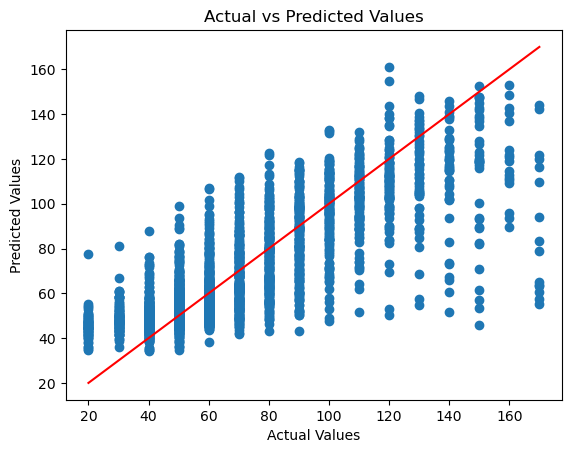

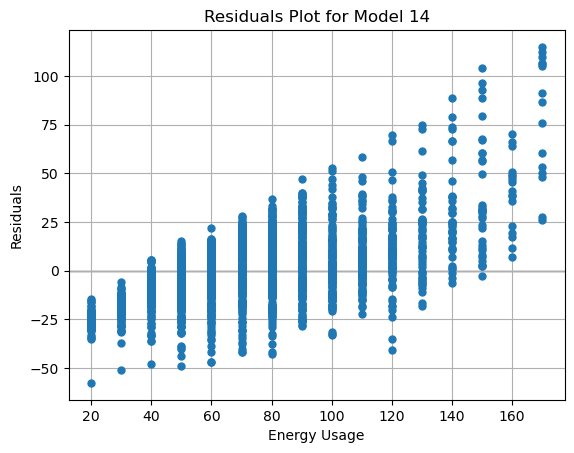

In [458]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model14 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model14.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history15 = model14.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

# r2 score
# Generate predictions
y_val_pred = model14.predict(X_val_transformed)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model 14", y_val, y_val_pred)

In [459]:
# add colkumn to check if day is weekday or weekend
X_train["is_weekend"] = X_train["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
X_val["is_weekend"] = X_val["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
X_test["is_weekend"] = X_test["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# power transform data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
# standard scale data
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)

#shape of the data
print("X_train shape: ", X_train.shape)

X_train shape:  (12267, 29)


In [460]:
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 512
REGULARIZATIONFACTOR = 0.0275
DROPOUT = 0.55
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)

# create model
model15 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model15.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history16 = model15.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

# r2 score
# Generate predictions
y_val_pred = model15.predict(X_val_transformedandscaled)
# Flatten predictions to 1D array
y_val_pred = y_val_pred.flatten()

# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)

print(f"R2 score: {r2}")


plt.scatter(y_val, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# residual plot
plot_residuals("Model 15", y_val, y_val_pred)

Epoch 1/100
24/24 - 3s - loss: 5766.3740 - mean_absolute_error: 69.8233 - root_mean_squared_error: 75.3827 - val_loss: 7646.4399 - val_mean_absolute_error: 80.2580 - val_root_mean_squared_error: 86.9675 - lr: 0.0015 - 3s/epoch - 134ms/step
Epoch 2/100
24/24 - 1s - loss: 5337.3945 - mean_absolute_error: 67.7238 - root_mean_squared_error: 72.4908 - val_loss: 6497.3032 - val_mean_absolute_error: 74.0186 - val_root_mean_squared_error: 80.0970 - lr: 0.0015 - 685ms/epoch - 29ms/step
Epoch 3/100
24/24 - 1s - loss: 4773.7974 - mean_absolute_error: 63.7130 - root_mean_squared_error: 68.5012 - val_loss: 4731.5508 - val_mean_absolute_error: 63.8859 - val_root_mean_squared_error: 68.1938 - lr: 0.0015 - 715ms/epoch - 30ms/step
Epoch 4/100
24/24 - 1s - loss: 3921.5012 - mean_absolute_error: 56.7620 - root_mean_squared_error: 61.9704 - val_loss: 3488.8662 - val_mean_absolute_error: 53.5578 - val_root_mean_squared_error: 58.3747 - lr: 0.0015 - 720ms/epoch - 30ms/step
Epoch 5/100
24/24 - 1s - loss: 287

In [475]:
#get metrics
calculate_metrics("Model 15", y_val, y_val_pred)

R2 Score for Model 15: 0.7734890532369544
Root Mean Squared Error for Model 15: 18.50446512995471
Mean Absolute Error for Model 15: 12.511450571016095


## ensemble learning

In [463]:
# change date column to datetime
energyUse_df["date"] = pd.to_datetime(energyUse_df["date"])





# add seconds from midnight column
energyUse_df["seconds_from_midnight"] = (
    energyUse_df["date"].dt.hour * 3600
    + energyUse_df["date"].dt.minute * 60
    + energyUse_df["date"].dt.second
)



# add day_of_week column
energyUse_df["day_of_week"] = energyUse_df["date"].dt.dayofweek

# add is_weekend column
energyUse_df["is_weekend"] = energyUse_df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# describe the data and print the first 5 rows
energyUse_df.describe()
energyUse_df.head()

date         T1       RH_1         T2       RH_2         T3  \
0 2016-04-19 20:30:00  22.200000  39.500000  20.566667  37.656667  22.230000   
1 2016-03-05 04:40:00  20.356667  37.126667  17.566667  40.230000  20.890000   
2 2016-03-14 12:40:00  20.926667  38.790000  21.100000  35.526667  21.600000   
3 2016-01-22 15:30:00  18.290000  38.900000  17.290000  39.260000  18.390000   
4 2016-02-10 00:40:00  22.290000  42.333333  21.600000  40.433333  22.666667   

        RH_3         T4       RH_4         T5  ...        rv1        rv2  \
0  37.030000  22.318571  36.610000  20.633333  ...  24.061869  24.061869   
1  37.663333  18.700000  36.260000  18.463333  ...   4.622052   4.622052   
2  36.290000  21.000000  34.826667  18.100000  ...   5.635898   5.635898   
3  39.326667  16.100000  38.790000  16.100000  ...  49.216445  49.216445   
4  43.363333  19.100000  40.900000  19.290000  ...  47.617579  47.617579   

   TARGET_energy  hour  day  month  year  seconds_from_midnight  day_of_week  \
0             60    20   19      4  2016                  73800            1   
1             50     4    5      3  2016                  16800            5   
2             80    12   14      3  2016                  45600            0   
3             40    15   22      1  2016                  55800            4   
4             60     0   10      2  2016                   2400            2   

   is_weekend  
0           0  
1           1  
2           0  
3           0  
4           0  

[5 rows x 35 columns]

In [464]:

# drop rows with missing values

energyUse_df = energyUse_df.dropna()


# split the data

train_data, test_data = train_test_split(energyUse_df, test_size=0.3, shuffle=True, random_state=42)

test_data, val_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=42)


# rebalance dataset by maually duplicating the instances of higher values

# Find the number of instances where the target is greater than 100

high_values = train_data[train_data["TARGET_energy"] > 100]

print("Number of instances with target greater than 100: ", high_values.shape[0])


# upsample the high values

train_data = pd.concat([train_data, high_values], ignore_index=True)

test_data = pd.concat([test_data, high_values], ignore_index=True)

val_data = pd.concat([val_data, high_values], ignore_index=True)


# remove the target column from the data

X_train = train_data.drop(columns=["TARGET_energy", "date"])

y_train = train_data["TARGET_energy"]

X_val = val_data.drop(columns=["TARGET_energy", "date"])

y_val = val_data["TARGET_energy"]

X_test = test_data.drop(columns=["TARGET_energy", "date"])

y_test = test_data["TARGET_energy"]

# # drop random variable columns
X_train = X_train.drop(columns=["rv1", "rv2"])
X_val = X_val.drop(columns=["rv1", "rv2"])
X_test = X_test.drop(columns=["rv1", "rv2"])

#drop rh6 and t6
X_train = X_train.drop(columns=["RH_6", "T6"])
X_val = X_val.drop(columns=["RH_6", "T6"])
X_test = X_test.drop(columns=["RH_6", "T6"])



Number of instances with target greater than 100:  1806


In [465]:
#standard scale the data and power transform the data
scaler = PowerTransformer(method="yeo-johnson").fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_val_transformed = scaler.transform(X_val)
X_test_transformed = scaler.transform(X_test)
scaler = StandardScaler().fit(X_train_transformed)
X_train_transformedandscaled = scaler.transform(X_train_transformed)
X_val_transformedandscaled = scaler.transform(X_val_transformed)
X_test_transformedandscaled = scaler.transform(X_test_transformed)

In [466]:
# weighted loss function
def weighted_loss(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)
    weights = tf.sqrt(y_true_float) + 1
    return tf.reduce_sum(weights * tf.square(y_true_float - y_pred))

In [467]:
# copy of models - so I don't have to keep scrolling
# model ensemble 1
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
REGULARIZATIONFACTOR = 0.03
DROPOUT = 0.50
learningrate = 0.002
DELTA = 1.0
optimizer = Adam(learning_rate=learningrate)



# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=20)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=20)


# create model
model_ensemble_1 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model_ensemble_1.compile(
    optimizer=optimizer,
    loss=weighted_loss,
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history_ensemble_1 = model_ensemble_1.fit(
    X_train_transformedandscaled,
    y_train,
    # sample_weight=sample_weights,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
55/55 - 4s - loss: 17985792.0000 - mean_absolute_error: 74.7198 - root_mean_squared_error: 80.9959 - val_loss: 46651616.0000 - val_mean_absolute_error: 110.2395 - val_root_mean_squared_error: 141.4007 - lr: 0.0020 - 4s/epoch - 81ms/step
Epoch 2/100
55/55 - 2s - loss: 11704274.0000 - mean_absolute_error: 59.6518 - root_mean_squared_error: 67.0110 - val_loss: 10539699.0000 - val_mean_absolute_error: 54.5141 - val_root_mean_squared_error: 60.6813 - lr: 0.0020 - 2s/epoch - 29ms/step
Epoch 3/100
55/55 - 2s - loss: 4129687.7500 - mean_absolute_error: 30.9720 - root_mean_squared_error: 38.5093 - val_loss: 2530950.2500 - val_mean_absolute_error: 22.0184 - val_root_mean_squared_error: 29.1732 - lr: 0.0020 - 2s/epoch - 36ms/step
Epoch 4/100
55/55 - 2s - loss: 1847494.3750 - mean_absolute_error: 19.8712 - root_mean_squared_error: 26.2071 - val_loss: 1789147.8750 - val_mean_absolute_error: 18.8319 - val_root_mean_squared_error: 25.3972 - lr: 0.0020 - 2s/epoch - 31ms/step
Epoch 5/100
55

139/139 [==============================] - 1s 3ms/step


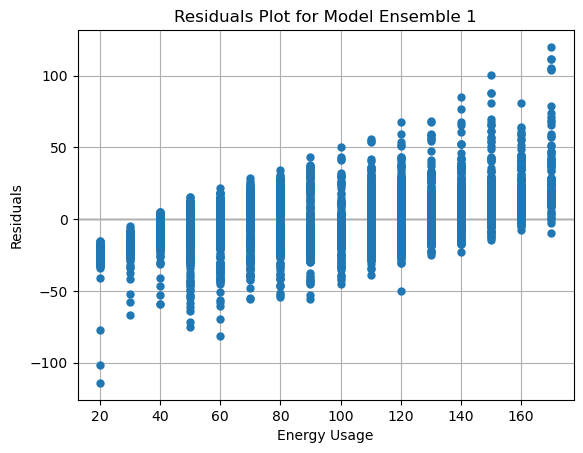

R2 score: 0.7871597985780591
RMSE: 17.937370113982134
MAE: 12.62139871762866


In [468]:
# get predictions
y_val_pred = model_ensemble_1.predict(X_val_transformedandscaled)
# flatten predictions
y_val_pred = y_val_pred.flatten()

plot_residuals("Model Ensemble 1", y_val, y_val_pred)

# get scores
# Calculate R2 score
r2 = r2_score(y_val, y_val_pred)
print(f"R2 score: {r2}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"RMSE: {rmse}")
# Calculate MAE
mae = mean_absolute_error(y_val, y_val_pred)
print(f"MAE: {mae}")

In [469]:
# model 15
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
REGULARIZATIONFACTOR = 0.035
DROPOUT = 0.50
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.07, patience=15)

# create model
model15 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model15.compile(
    optimizer=optimizer,
    loss=Huber(),
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history16 = model15.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
55/55 - 4s - loss: 144.4053 - mean_absolute_error: 75.3009 - root_mean_squared_error: 83.1877 - val_loss: 114.8926 - val_mean_absolute_error: 85.8840 - val_root_mean_squared_error: 94.2757 - lr: 0.0015 - 4s/epoch - 77ms/step
Epoch 2/100
55/55 - 2s - loss: 81.4374 - mean_absolute_error: 61.1371 - root_mean_squared_error: 70.9787 - val_loss: 75.9586 - val_mean_absolute_error: 59.8639 - val_root_mean_squared_error: 70.4432 - lr: 0.0015 - 2s/epoch - 33ms/step
Epoch 3/100
55/55 - 2s - loss: 47.6514 - mean_absolute_error: 34.5980 - root_mean_squared_error: 45.9184 - val_loss: 44.4131 - val_mean_absolute_error: 32.8469 - val_root_mean_squared_error: 43.2532 - lr: 0.0015 - 2s/epoch - 34ms/step
Epoch 4/100
55/55 - 2s - loss: 32.5714 - mean_absolute_error: 21.3773 - root_mean_squared_error: 29.5126 - val_loss: 31.4175 - val_mean_absolute_error: 20.8940 - val_root_mean_squared_error: 29.0704 - lr: 0.0015 - 2s/epoch - 32ms/step
Epoch 5/100
55/55 - 2s - loss: 29.1041 - mean_absolute_err

139/139 [==============================] - 1s 4ms/step


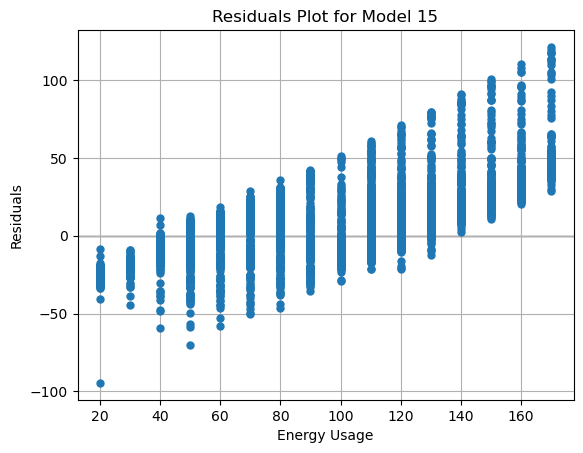

R2 Score for Model 15: 0.6401814442371183
Root Mean Squared Error for Model 15: 23.322425621853682
Mean Absolute Error for Model 15: 15.853377508445146


In [477]:
# plot residual plot
# get predictions
y_val_pred = model15.predict(X_val_transformedandscaled)
# flatten predictions
y_val_pred = y_val_pred.flatten()
plot_residuals("Model 15", y_val, y_val_pred)

# cakuculate metrics
calculate_metrics("Model 15", y_val, y_val_pred)

In [471]:
# model 16
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
REGULARIZATIONFACTOR = 0.03
DROPOUT = 0.50
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.07, patience=15)

# create model
model16 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model16.compile(
    optimizer=optimizer,
    loss=weighted_loss,
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history17 = model16.fit(
    X_train_transformedandscaled,
    y_train,
    validation_data=(X_val_transformedandscaled, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
55/55 - 5s - loss: 18659844.0000 - mean_absolute_error: 75.8739 - root_mean_squared_error: 81.9674 - val_loss: 40548272.0000 - val_mean_absolute_error: 105.6712 - val_root_mean_squared_error: 130.0407 - lr: 0.0015 - 5s/epoch - 82ms/step
Epoch 2/100
55/55 - 2s - loss: 14122499.0000 - mean_absolute_error: 66.8455 - root_mean_squared_error: 73.7556 - val_loss: 16595431.0000 - val_mean_absolute_error: 71.7366 - val_root_mean_squared_error: 77.3739 - lr: 0.0015 - 2s/epoch - 35ms/step
Epoch 3/100
55/55 - 2s - loss: 8112598.0000 - mean_absolute_error: 47.8169 - root_mean_squared_error: 54.7855 - val_loss: 6312352.0000 - val_mean_absolute_error: 39.7744 - val_root_mean_squared_error: 46.4951 - lr: 0.0015 - 2s/epoch - 37ms/step
Epoch 4/100
55/55 - 2s - loss: 3178629.5000 - mean_absolute_error: 26.4382 - root_mean_squared_error: 33.5114 - val_loss: 2655061.2500 - val_mean_absolute_error: 22.4843 - val_root_mean_squared_error: 29.6643 - lr: 0.0015 - 2s/epoch - 35ms/step
Epoch 5/100
55

In [478]:
# plot residual plot
# get predictions
y_val_pred = model16.predict(X_val_transformedandscaled)
# flatten predictions
y_val_pred = y_val_pred.flatten()
plot_residuals("Model 16", y_val, y_val_pred)

# cakuculate metrics
calculate_metrics("Model 16", y_val, y_val_pred)


139/139 [==============================] - 0s 3ms/step


R2 Score for Model 16: 0.7858031283911837
Root Mean Squared Error for Model 16: 17.994446830372294
Mean Absolute Error for Model 16: 12.768543096325175


In [479]:
# model 21 - decision tree regressor
model21 = DecisionTreeRegressor(max_depth=30, min_samples_split=10, min_samples_leaf=10)

#weight is cube of y
weights = np.power(y_train, 2)

model21.fit(X_train_transformedandscaled, y_train, sample_weight=weights)


#plot residuals
plot_residuals("Model 21", y_val, y_val_pred)

#calculate metrics
calculate_metrics("Model 21", y_val, y_val_pred)





R2 Score for Model 21: 0.7858031283911837
Root Mean Squared Error for Model 21: 17.994446830372294
Mean Absolute Error for Model 21: 12.768543096325175


In [474]:
# model 22 - neural network but ensemble
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
REGULARIZATIONFACTOR = 0.03
DROPOUT = 0.50
learningrate = 0.002
DELTA = 1.0
optimizer = Adam(learning_rate=learningrate)

# get values over 100
threshold = 80

# Split the training data into two subsets
X_train_low = X_train_transformedandscaled[y_train <= threshold]
y_train_low = y_train[y_train <= threshold]
X_train_high = X_train_transformedandscaled[y_train > threshold]
y_train_high = y_train[y_train > threshold]
# Split the validation data into two subsets
# Split the validation data into two subsets
X_val_low = X_val_transformedandscaled[y_val <= threshold]
y_val_low = y_val[y_val <= threshold]
X_val_high = X_val_transformedandscaled[y_val > threshold]
y_val_high = y_val[y_val > threshold]

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)


# create model_low_values
model_low_values = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model_low_values.compile(
    optimizer=optimizer,
    loss=weighted_loss,
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history_low_values = model_low_values.fit(
    X_train_low,
    y_train_low,
    # sample_weight=sample_weights,
    validation_data=(X_val_low, y_val_low),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/100
35/35 - 4s - loss: 6688793.0000 - mean_absolute_error: 53.0970 - root_mean_squared_error: 54.8676 - val_loss: 8833607.0000 - val_mean_absolute_error: 61.1518 - val_root_mean_squared_error: 65.2409 - lr: 0.0020 - 4s/epoch - 125ms/step
Epoch 2/100
35/35 - 1s - loss: 5100542.5000 - mean_absolute_error: 45.7341 - root_mean_squared_error: 47.8683 - val_loss: 4241909.0000 - val_mean_absolute_error: 41.5443 - val_root_mean_squared_error: 44.6809 - lr: 0.0020 - 1s/epoch - 32ms/step
Epoch 3/100
35/35 - 2s - loss: 2456076.0000 - mean_absolute_error: 29.6354 - root_mean_squared_error: 32.9633 - val_loss: 1265887.1250 - val_mean_absolute_error: 20.6731 - val_root_mean_squared_error: 24.0339 - lr: 0.0020 - 2s/epoch - 44ms/step
Epoch 4/100
35/35 - 1s - loss: 707131.3750 - mean_absolute_error: 14.2102 - root_mean_squared_error: 17.6408 - val_loss: 487203.6562 - val_mean_absolute_error: 11.8674 - val_root_mean_squared_error: 15.0193 - lr: 0.0020 - 1s/epoch - 31ms/step
Epoch 5/100
35/35 - 1

KeyboardInterrupt: 

In [ ]:
# model 22 - neural network but ensemble
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
REGULARIZATIONFACTOR = 0.03
DROPOUT = 0.50
learningrate = 0.002
DELTA = 1.0
optimizer = Adam(learning_rate=learningrate)
# create model_high_values
model_high_values = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model_high_values.compile(
    optimizer=optimizer,
    loss=weighted_loss,
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history_high_values = model_high_values.fit(
    X_train_high,
    y_train_high,
    # sample_weight=sample_weights,
    validation_data=(X_val_high, y_val_high),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
12/12 - 4s - loss: 44587876.0000 - mean_absolute_error: 120.4445 - root_mean_squared_error: 120.8937 - val_loss: 46711240.0000 - val_mean_absolute_error: 123.8532 - val_root_mean_squared_error: 124.4117 - lr: 0.0020 - 4s/epoch - 319ms/step
Epoch 2/100
12/12 - 0s - loss: 43859924.0000 - mean_absolute_error: 119.3968 - root_mean_squared_error: 119.8541 - val_loss: 41127828.0000 - val_mean_absolute_error: 116.2115 - val_root_mean_squared_error: 116.7329 - lr: 0.0020 - 387ms/epoch - 32ms/step
Epoch 3/100
12/12 - 0s - loss: 42520136.0000 - mean_absolute_error: 117.5976 - root_mean_squared_error: 118.0754 - val_loss: 40633452.0000 - val_mean_absolute_error: 115.5686 - val_root_mean_squared_error: 116.0350 - lr: 0.0020 - 329ms/epoch - 27ms/step
Epoch 4/100
12/12 - 0s - loss: 40577652.0000 - mean_absolute_error: 114.8086 - root_mean_squared_error: 115.3195 - val_loss: 39516152.0000 - val_mean_absolute_error: 113.8190 - val_root_mean_squared_error: 114.4340 - lr: 0.0020 - 336ms/epoc

(2236, 25)
(1746, 25)
55/55 [==============================] - 0s 2ms/step
R2 score: 0.898224408080503
RMSE: 10.827374168359846


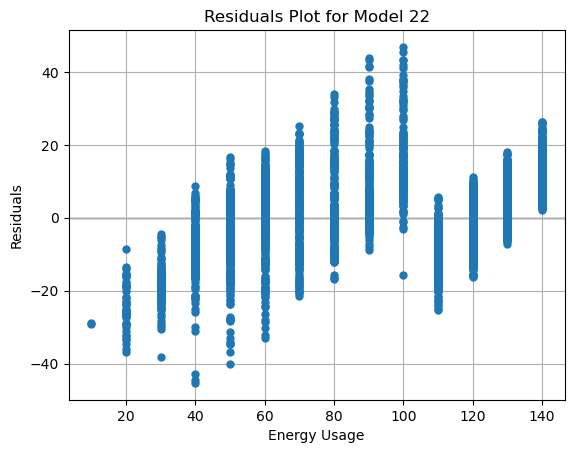

56/56 [==============================] - 0s 2ms/step
Test R2 score: 0.9036245472080249
Test RMSE: 10.658368879630164


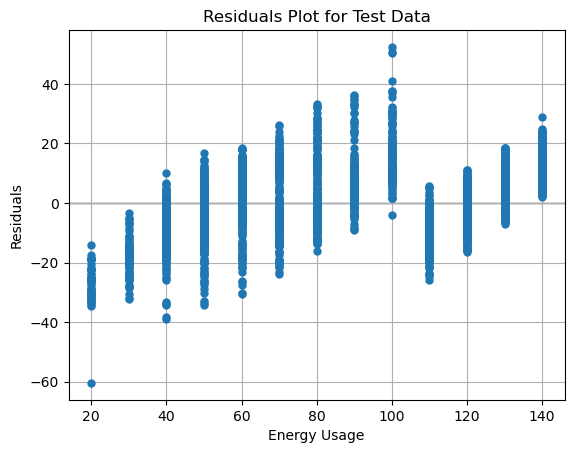

In [ ]:
print(X_val_low.shape)
print(X_val_high.shape)

# Use the appropriate model to make predictions for each subset
y_val_pred_low = model_low_values.predict(X_val_low).flatten()
y_val_pred_high = model_high_values.predict(X_val_high).flatten()

# Concatenate the predictions and the true values
y_val_pred = np.concatenate([y_val_pred_low, y_val_pred_high])
y_val_true = np.concatenate([y_val[y_val <= threshold], y_val[y_val > threshold]])

# Flatten the predictions
y_val_pred = y_val_pred.flatten()
# Calculate R2 score
r2 = r2_score(y_val_true, y_val_pred)
print(f"R2 score: {r2}")
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
print(f"RMSE: {rmse}")
# plot residuals
plot_residuals("Model 22", y_val_true, y_val_pred)

# scatter plot of actual vs predicted values
plt.scatter(y_val_true, y_val_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val_true.min(), y_val_true.max()], [y_val_true.min(), y_val_true.max()], color="red"
)  # y=x line
plt.show()


In [ ]:
# list of models
models = [model16, model15, model14, model21]


# stacking models
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
learningrate = 0.0015
optimizer = Adam(learning_rate=learningrate)

# create meta features
# create meta features
meta_features = np.column_stack(
    [model.predict(X_train_transformedandscaled).reshape(-1, 1) for model in models] +
     [model_low_values.predict(X_train_transformedandscaled).reshape(-1, 1), model_high_values.predict(X_train_transformedandscaled).reshape(-1, 1)]

)

# create meta features for validation data
meta_val_features = np.column_stack(
    [model.predict(X_val_transformedandscaled).reshape(-1, 1) for model in models]+
    [
        model_low_values.predict(X_val_transformedandscaled).reshape(-1, 1),
        model_high_values.predict(X_val_transformedandscaled).reshape(-1, 1),
    ]
)


meta_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=6),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_regularizer=regularizers.l2(0.5),  # L2 regularization
        ),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_regularizer=regularizers.l2(0.5),  # L2 regularization
        ),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_regularizer=regularizers.l2(0.5),  # L2 regularization
        ),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)
# Compile the meta-model
meta_model.compile(
    loss=weighted_loss,
    optimizer=optimizer,
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history_meta = meta_model.fit(
    meta_features,
    y_train,
    validation_data=(meta_val_features, y_val),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
)


# Make final predictions
final_predictions = meta_model.predict(meta_val_features)

# Calculate and print scores
r2 = r2_score(y_val, final_predictions)
rmse = np.sqrt(mean_squared_error(y_val, final_predictions))
mae = mean_absolute_error(y_val, final_predictions)
print(f"R2 score: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Create scatter and residual plots
plt.scatter(y_val, final_predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot(
    [y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red"
)  # y=x line
plt.show()

# flatten predictions
final_predictions_flat = final_predictions.flatten()
# Plot residuals
plot_residuals("Model Ensemble", y_val, final_predictions_flat)

125/125 [==============================] - 0s 2ms/step
Epoch 1/100
53/53 - 2s - loss: 1055045.2500 - mean_absolute_error: 13.7831 - root_mean_squared_error: 20.4466 - val_loss: 480645.1562 - val_mean_absolute_error: 9.9675 - val_root_mean_squared_error: 13.9269 - 2s/epoch - 29ms/step
Epoch 2/100
53/53 - 1s - loss: 312323.0625 - mean_absolute_error: 8.5799 - root_mean_squared_error: 11.6223 - val_loss: 505085.0000 - val_mean_absolute_error: 10.1890 - val_root_mean_squared_error: 13.9791 - 536ms/epoch - 10ms/step
Epoch 3/100
53/53 - 1s - loss: 308102.3438 - mean_absolute_error: 8.5157 - root_mean_squared_error: 11.5270 - val_loss: 475445.2812 - val_mean_absolute_error: 9.8410 - val_root_mean_squared_error: 13.7515 - 571ms/epoch - 11ms/step
Epoch 4/100
53/53 - 0s - loss: 298461.2188 - mean_absolute_error: 8.3745 - root_mean_squared_error: 11.3611 - val_loss: 563854.7500 - val_mean_absolute_error: 10.8352 - val_root_mean_squared_error: 14.5369 - 490ms/epoch - 9ms/step
Epoch 5/100
53/53 - 1

In [ ]:
# weighted loss function - copy
def weighted_loss(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)
    weights = tf.sqrt(y_true_float) + 1
    return tf.reduce_sum(weights * tf.square(y_true_float - y_pred))

In [491]:
# Best Model - model 22

# model 22 - neural network but ensemble
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 512
OUTPUT_CLASSES = 1
BATCH_SIZE = 256
REGULARIZATIONFACTOR = 0.03
DROPOUT = 0.50
learningrate = 0.002
DELTA = 1.0
optimizer = Adam(learning_rate=learningrate)



# get values over 100
threshold = 100



# Split the training data into two subsets
X_train_low = X_train_transformedandscaled[y_train <= threshold]
y_train_low = y_train[y_train <= threshold]
X_train_high = X_train_transformedandscaled[y_train > threshold]
y_train_high = y_train[y_train > threshold]

# Split the validation data into two subsets
X_val_low = X_val_transformedandscaled[y_val <= threshold]
y_val_low = y_val[y_val <= threshold]
X_val_high = X_val_transformedandscaled[y_val > threshold]
y_val_high = y_val[y_val > threshold]

# Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=15)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15)


# create model_low_values
model_low_values = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model_low_values.compile(
    optimizer=optimizer,
    loss=weighted_loss,
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history_low_values = model_low_values.fit(
    X_train_low,
    y_train_low,
    validation_data=(X_val_low, y_val_low),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

# create model_high_values
model_high_values = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(INPUT_DIM)),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(
            HIDDEN_LAYER_DIM,
            activation="relu",
            kernel_initializer="he_normal",
            kernel_regularizer=regularizers.l2(REGULARIZATIONFACTOR),
        ),
        Dropout(DROPOUT),
        BatchNormalization(),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_initializer="he_normal"),
    ]
)

# compile model
model_high_values.compile(
    optimizer=optimizer,
    loss=weighted_loss,
    metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()],
)

# train the model
history_high_values = model_high_values.fit(
    X_train_high,
    y_train_high,
    validation_data=(X_val_high, y_val_high),
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
)

# Use the appropriate model to make predictions for each subset
y_val_pred_low = model_low_values.predict(X_val_low).flatten()
y_val_pred_high = model_high_values.predict(X_val_high).flatten()

# Concatenate the predictions and the true values
y_val_pred = np.concatenate([y_val_pred_low, y_val_pred_high])
y_val_true = np.concatenate([y_val[y_val <= threshold], y_val[y_val > threshold]])

# Flatten the predictions
y_val_pred = y_val_pred.flatten()
# calcul;ate metrics
calculate_metrics("Model 22", y_val_true, y_val_pred)

# plot residuals
plot_residuals("Model 22", y_val_true, y_val_pred)

# scatter plot of actual vs predicted values
scatter_plot(y_val_true, y_val_pred, "Best Model")

Epoch 1/100
41/41 - 4s - loss: 8889026.0000 - mean_absolute_error: 58.5949 - root_mean_squared_error: 61.4561 - val_loss: 15380863.0000 - val_mean_absolute_error: 75.8916 - val_root_mean_squared_error: 84.9184 - lr: 0.0020 - 4s/epoch - 99ms/step
Epoch 2/100
41/41 - 2s - loss: 6388344.5000 - mean_absolute_error: 48.8629 - root_mean_squared_error: 52.1248 - val_loss: 4949764.5000 - val_mean_absolute_error: 42.5622 - val_root_mean_squared_error: 46.8768 - lr: 0.0020 - 2s/epoch - 41ms/step
Epoch 3/100
41/41 - 2s - loss: 2606894.5000 - mean_absolute_error: 28.2320 - root_mean_squared_error: 32.9010 - val_loss: 1063923.8750 - val_mean_absolute_error: 17.0516 - val_root_mean_squared_error: 21.0155 - lr: 0.0020 - 2s/epoch - 44ms/step
Epoch 4/100
41/41 - 2s - loss: 801697.1250 - mean_absolute_error: 14.3967 - root_mean_squared_error: 18.4147 - val_loss: 540259.2500 - val_mean_absolute_error: 11.9430 - val_root_mean_squared_error: 15.5776 - lr: 0.0020 - 2s/epoch - 49ms/step
Epoch 5/100
41/41 - 2

70/70 [==============================] - 0s 2ms/step
R2 Score for Model 22: 0.900497733068086
Root Mean Squared Error for Model 22: 12.256191456067864
Mean Absolute Error for Model 22: 9.098678092139416


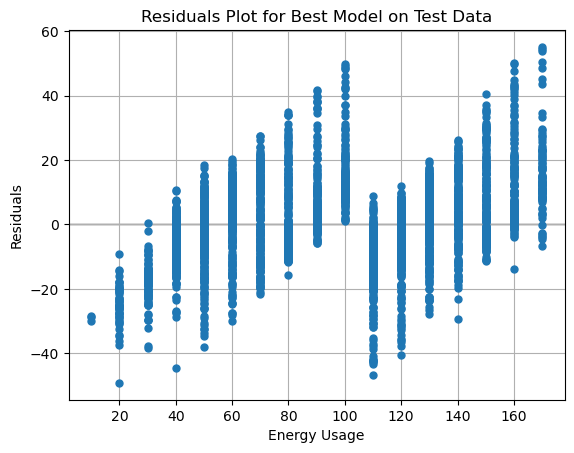

In [496]:
# best model on test data
# split test data
X_test_low = X_test_transformedandscaled[y_test <= threshold]
y_test_low = y_test[y_test <= threshold]
X_test_high = X_test_transformedandscaled[y_test > threshold]
y_test_high = y_test[y_test > threshold]

# Use the appropriate model to make predictions for each subset
y_test_pred_low = model_low_values.predict(X_test_low).flatten()
y_test_pred_high = model_high_values.predict(X_test_high).flatten()

# Concatenate the predictions and the true values
y_test_pred = np.concatenate([y_test_pred_low, y_test_pred_high])
y_test_true = np.concatenate([y_test[y_test <= threshold], y_test[y_test > threshold]])

# Flatten the predictions
y_test_pred = y_test_pred.flatten()
# calculate metrics
calculate_metrics("Model 22", y_test_true, y_test_pred)

# plot residuals
plot_residuals("Best Model on Test Data", y_test_true, y_test_pred)

# scatter plot of actual vs predicted values
scatter_plot( y_test_true, y_test_pred, "Best Model - Test Data" )